In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install missingno
import missingno as msno

In [389]:
# train data 불러오기
df_train = pd.read_csv("../data/train_heat.csv", index_col=0)
df_train

,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
1,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
2,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
3,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
4,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
5,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...
499297,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499298,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499299,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499300,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


In [390]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [391]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [392]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [393]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


In [394]:
# -9.9 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ta_chi']


In [395]:
# -9.9를 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-9.9' 포함 열:", cols_with_neg99)

'-9.9' 포함 열: ['ta', 'ta_chi']


In [396]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
wd                   20404           4.086513
rn_hr1               19154           3.836163
ws                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


In [397]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [398]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [399]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day'] = df_train['tm'].dt.day # 월
df_train['hour'] = df_train['tm'].dt.hour
df_train['date'] = df_train['tm'].dt.date
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [400]:
# 공통 규칙 정의

# A,B,C,F
common_night_rules_1 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 13), 21, 6),
    ((4, 13), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 12), 20, 6),
    ((10, 12), (11, 3), 19, 6),
    ((11, 3), (12, 31), 19, 7)
]

# D,E,G,H,I,J,K,S
common_night_rules_2 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 4), 19, 6),
    ((11, 4), (12, 31), 19, 7)
]

# L,M,N
common_night_rules_3 = [
    ((1, 1), (2, 10), 19, 7),
    ((2, 10), (2, 25), 20, 7),
    ((2, 25), (4, 9), 20, 6),
    ((4, 9), (4, 19), 20, 5),
    ((4, 19), (8, 26), 21, 5),
    ((8, 26), (9, 4), 20, 5),
    ((9, 4), (10, 7), 20, 6),
    ((10, 7), (11, 13), 19, 6),
    ((11, 13), (12, 31), 19, 7)
]

# O
common_night_rules_4 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 2), 20, 7),
    ((3, 2), (4, 11), 20, 6),
    ((4, 11), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 1), 21, 6),
    ((9, 1), (10, 11), 20, 6),
    ((10, 11), (11, 7), 19, 6),
    ((11, 7), (12, 31), 19, 7)
]

# P
common_night_rules_5 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 3), 20, 7),
    ((3, 3), (4, 10), 20, 6),
    ((4, 10), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 2), 21, 6),
    ((9, 2), (10, 12), 20, 6),
    ((10, 12), (11, 6), 19, 6),
    ((11, 6), (12, 31), 19, 7)
]

# Q
common_night_rules_6 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 5), 20, 7),
    ((3, 5), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 2), 19, 6),
    ((11, 2), (12, 31), 19, 7)
]

# R
common_night_rules_7 = [
    ((1, 1), (2, 1), 19, 7),
    ((2, 1), (3, 2), 20, 7),
    ((3, 2), (4, 9), 20, 6),
    ((4, 9), (4, 15), 21, 6),
    ((4, 15), (8, 26), 21, 5),
    ((8, 26), (9, 2), 21, 6),
    ((9, 2), (10, 14), 20, 6),
    ((10, 14), (11, 8), 19, 6),
    ((11, 8), (12, 31), 19, 7)
]


# 브랜치별 야간 시간 규칙 딕셔너리
branch_night_rules = {
    'A': common_night_rules_1,
    'B': common_night_rules_1,
    'C': common_night_rules_1,
    'D': common_night_rules_2,
    'E': common_night_rules_2,
    'F': common_night_rules_1,
    'G': common_night_rules_2,
    'H': common_night_rules_2,
    'I': common_night_rules_2,
    'J': common_night_rules_2,
    'K': common_night_rules_2,
    'L': common_night_rules_3,
    'M': common_night_rules_3,
    'N': common_night_rules_3,
    'O': common_night_rules_4,
    'P': common_night_rules_5,
    'Q': common_night_rules_6,
    'R': common_night_rules_7,
    'S': common_night_rules_2
}


In [401]:
# 모든 브랜치에 대해 야간 시간 적용
for branch, rules in branch_night_rules.items():
    is_branch = df_train['branch_id'] == branch

    for (start_m, start_d), (end_m, end_d), night_start, night_end in rules:
        in_period = (
            ((df_train['month'] > start_m) | ((df_train['month'] == start_m) & (df_train['day'] >= start_d))) &
            ((df_train['month'] < end_m) | ((df_train['month'] == end_m) & (df_train['day'] <= end_d)))
        )

        if night_start > night_end:  # 자정을 넘기는 경우
            in_night = (df_train['hour'] >= night_start) | (df_train['hour'] <= night_end)
        else:
            in_night = (df_train['hour'] >= night_start) & (df_train['hour'] < night_end)

        # 조건에 맞는 행에 대해 si 값 0으로 설정
        mask = is_branch & in_period & in_night
        df_train.loc[mask, 'si'] = 0

In [402]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
hm              39711           7.953685
wd              20402           4.086301
rn_hr1          19152           3.835939
ws              18813           3.768041
rn_day          18624           3.730186
ta              12995           2.602758
si              10347           2.072393
ta_chi             20           0.004006


In [403]:
cluster2_branch_ids = ['A', 'D', 'H', 'P']
df_train_cluster2 = df_train[df_train['branch_id'].isin(cluster2_branch_ids)]

In [404]:
df_train_cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105112 entries, 0 to 420444
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           105112 non-null  datetime64[ns]
 1   branch_id    105112 non-null  object        
 2   ta           101226 non-null  float64       
 3   wd           98176 non-null   float64       
 4   ws           98948 non-null   float64       
 5   rn_day       99552 non-null   float64       
 6   rn_hr1       99424 non-null   float64       
 7   hm           97099 non-null   float64       
 8   si           95238 non-null   float64       
 9   ta_chi       105111 non-null  float64       
 10  heat_demand  105112 non-null  float64       
 11  year         105112 non-null  int32         
 12  quarter      105112 non-null  int32         
 13  month        105112 non-null  int32         
 14  day          105112 non-null  int32         
 15  hour         105112 non-null  int32    

In [405]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train_cluster2.isnull().sum(),
    'Missing Ratio (%)': df_train_cluster2.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
si               9874           9.393789
hm               8013           7.623297
wd               6936           6.598676
ws               6164           5.864221
rn_hr1           5688           5.411371
rn_day           5560           5.289596
ta               3886           3.697009
ta_chi              1           0.000951


c:\Users\smlee\Desktop\python\.venv2\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


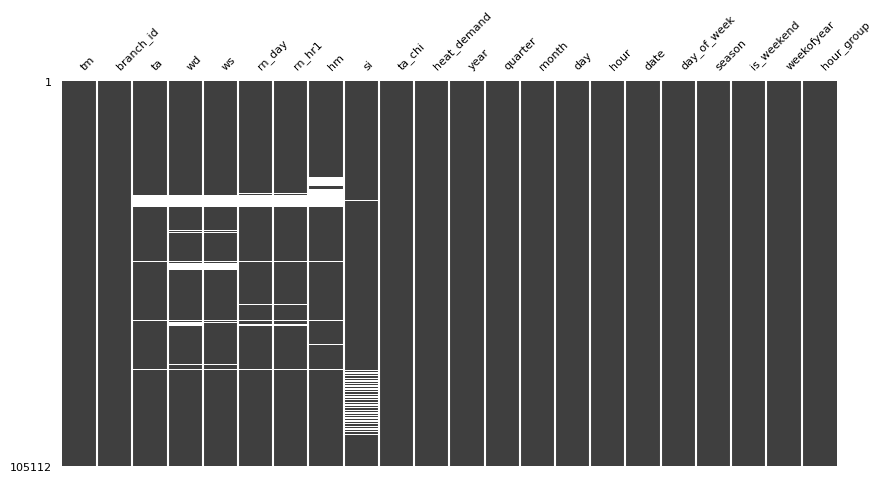

In [134]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train_cluster2,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

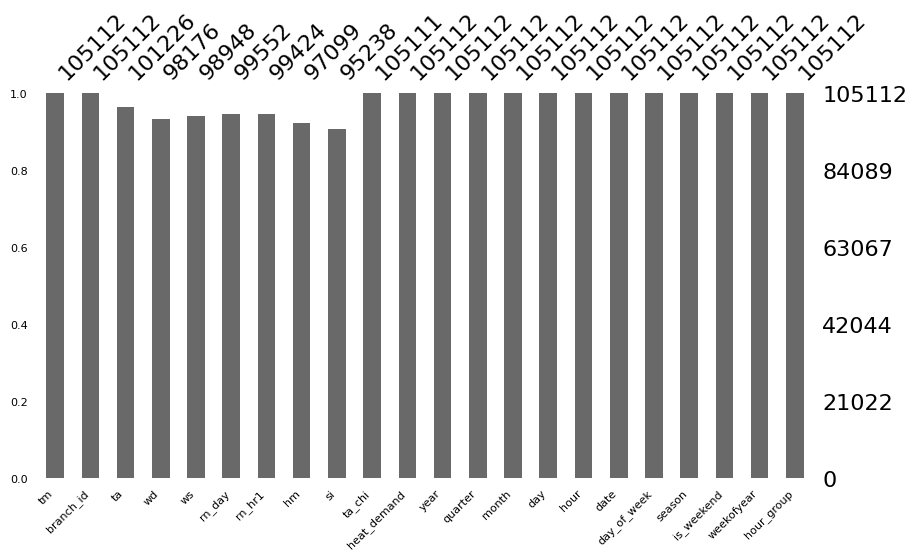

In [135]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train_cluster2, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

In [137]:
df_train_cluster2.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day,hour,day_of_week,weekofyear,hour_group
ta,1.000000,-0.140137,0.056788,0.115358,0.071108,0.154649,0.314191,0.993075,-0.833311,0.030424,0.211025,0.204085,-0.011400,0.135774,0.000459,0.169121,0.136722
wd,-0.140137,1.000000,-0.046796,-0.025252,-0.030753,-0.081020,-0.019002,-0.160087,0.162263,-0.002019,-0.027940,-0.027758,-0.004670,0.031456,0.004869,-0.021585,0.031554
ws,0.056788,-0.046796,1.000000,0.060819,0.061118,-0.347236,0.353981,0.018171,-0.009007,-0.017790,-0.077368,-0.069603,-0.005093,0.183075,-0.011921,-0.072945,0.184266
rn_day,0.115358,-0.025252,0.060819,1.000000,0.446930,0.233637,-0.069151,0.134271,-0.107147,0.040444,0.040656,0.039831,-0.003088,0.088651,-0.029032,0.035906,0.089815
rn_hr1,0.071108,-0.030753,0.061118,0.446930,1.000000,0.177923,-0.065303,0.086352,-0.074418,0.021479,0.027545,0.026901,-0.004546,0.002319,-0.021516,0.024235,0.002278
hm,0.154649,-0.081020,-0.347236,0.233637,0.177923,1.000000,-0.496618,0.212043,-0.262091,0.027379,0.250998,0.247679,0.026404,-0.272024,-0.007905,0.238452,-0.273962
si,0.314191,-0.019002,0.353981,-0.069151,-0.065303,-0.496618,1.000000,0.274789,-0.137929,0.044146,-0.052907,-0.053014,-0.013508,0.151263,0.004395,-0.058648,0.152456
ta_chi,0.993075,-0.160087,0.018171,0.134271,0.086352,0.212043,0.274789,1.000000,-0.841420,0.013631,0.207832,0.202900,-0.004217,0.117695,0.001459,0.170036,0.118524
heat_demand,-0.833311,0.162263,-0.009007,-0.107147,-0.074418,-0.262091,-0.137929,-0.841420,1.000000,-0.009193,-0.246101,-0.235967,0.004958,0.044414,-0.022247,-0.199135,0.044682
year,0.030424,-0.002019,-0.017790,0.040444,0.021479,0.027379,0.044146,0.013631,-0.009193,1.000000,-0.000047,-0.000066,-0.000107,-0.000117,0.001142,-0.000134,-0.000109


## Target 분석

##### **(1) 일별 열수요 평균**

In [95]:
daily_avg_df_cluster2 = (
    df_train_cluster2.copy()
    .assign(date=lambda x: x['tm'].dt.date)
    .groupby('date')['heat_demand']
    .mean()
)

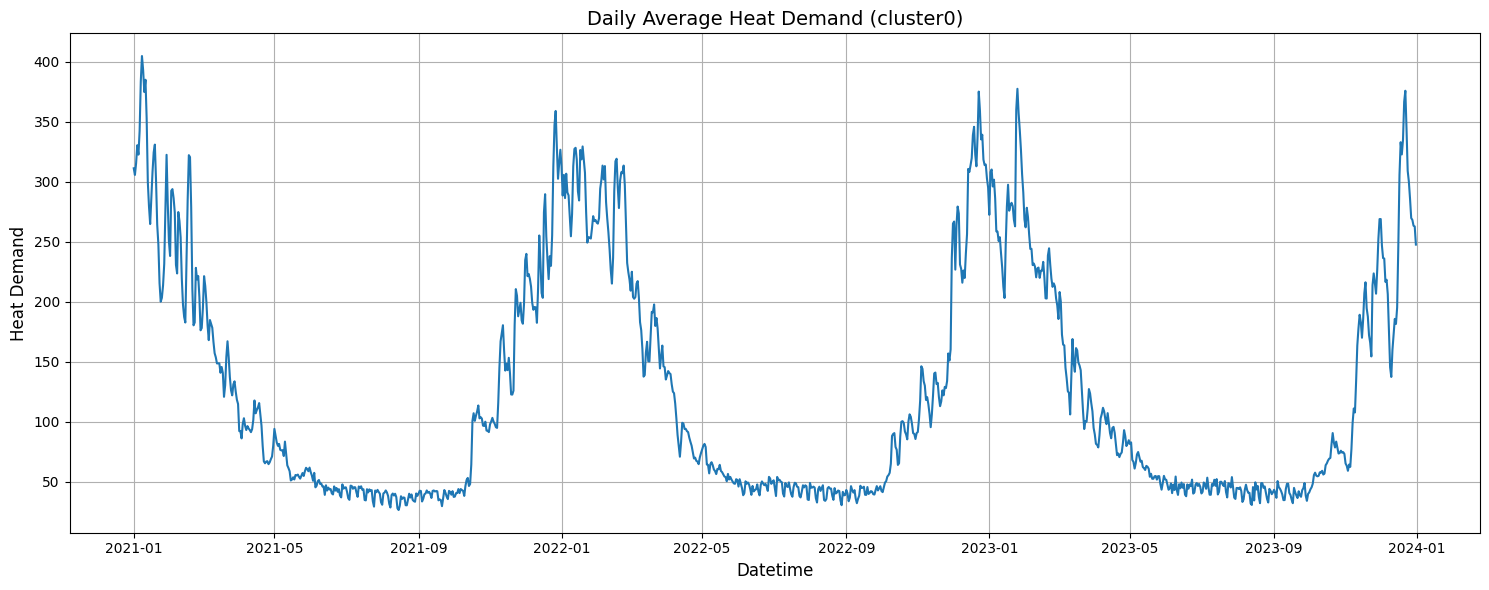

In [96]:
# 시도표
plt.figure(figsize=(15, 6))
plt.plot(daily_avg_df_cluster2.index, daily_avg_df_cluster2.values)
plt.title('Daily Average Heat Demand (cluster0)', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Heat Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(2) 분포 시각화**

In [97]:
def plot_heat_demand_distribution(df, column_name='heat_demand', title='Distribution of Heat Demand'):
    """
    데이터프레임과 컬럼명을 받아서 평균, 중앙값, 최빈값을 계산하고
    박스플롯과 히스토그램(분포)을 그리는 함수입니다.
    """
    mean = df[column_name].mean()
    median = df[column_name].median()
    mode = df[column_name].mode()[0]

    fig, (ax_box, ax_hist) = plt.subplots(
        2, 1,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=(12, 6),
        sharex=True
    )

    fig.suptitle(title, fontsize=18, fontweight='bold')

    # 박스플롯
    sns.boxplot(
        x=df[column_name],
        showmeans=True,
        orient='h',
        color='lightblue',
        ax=ax_box
    )
    ax_box.set(xlabel='')

    # 히스토그램 + 평균/중앙값/최빈값 선
    sns.histplot(df[column_name], bins=100, kde=True, color='skyblue', ax=ax_hist)
    ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
    ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
    ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')

    ax_hist.set_xlabel(column_name, fontsize=12)
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.grid(True)
    ax_hist.legend()

    plt.tight_layout()
    plt.show()


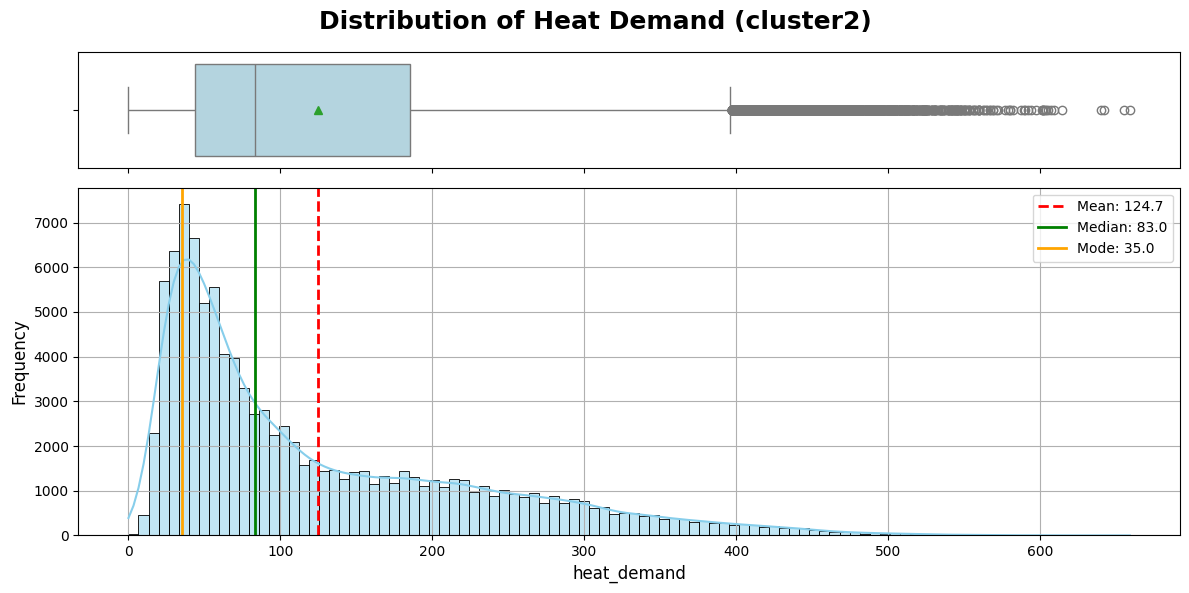

In [98]:
plot_heat_demand_distribution(df_train_cluster2, column_name='heat_demand', title='Distribution of Heat Demand (cluster2)')


-  브랜치별로 확인

In [99]:
def plot_heat_demand_distribution(df, column_name='heat_demand', title='Distribution of Heat Demand'):
    """
    데이터프레임과 컬럼명을 받아서 평균, 중앙값, 최빈값을 계산하고
    박스플롯과 히스토그램(분포)을 그리는 함수입니다.
    """
    mean = df[column_name].mean()
    median = df[column_name].median()
    mode_series = df[column_name].mode()  # 수정된 부분: Series로 받기
    
    # 모드 값 처리 (최빈값이 없을 경우 None)
    mode = mode_series[0] if not mode_series.empty else None

    fig, (ax_box, ax_hist) = plt.subplots(
        2, 1,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=(12, 6),
        sharex=True
    )

    fig.suptitle(title, fontsize=18, fontweight='bold')

    # 박스플롯
    sns.boxplot(
        x=df[column_name],
        showmeans=True,
        orient='h',
        color='lightblue',
        ax=ax_box
    )
    ax_box.set(xlabel='')

    # 히스토그램 + 평균/중앙값/최빈값 선
    sns.histplot(df[column_name], bins=100, kde=True, color='skyblue', ax=ax_hist)
    ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
    ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
    
    # 최빈값 선 추가 (값이 있을 경우만)
    if mode is not None:
        ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')  # 수정된 부분

    # x축, y축 범위 통일
    ax_hist.set_xlim(0, 700)
    ax_hist.set_ylim(0, 1800)

    ax_hist.set_xlabel(column_name, fontsize=12)
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.grid(True)
    ax_hist.legend()

    plt.tight_layout()
    plt.show()


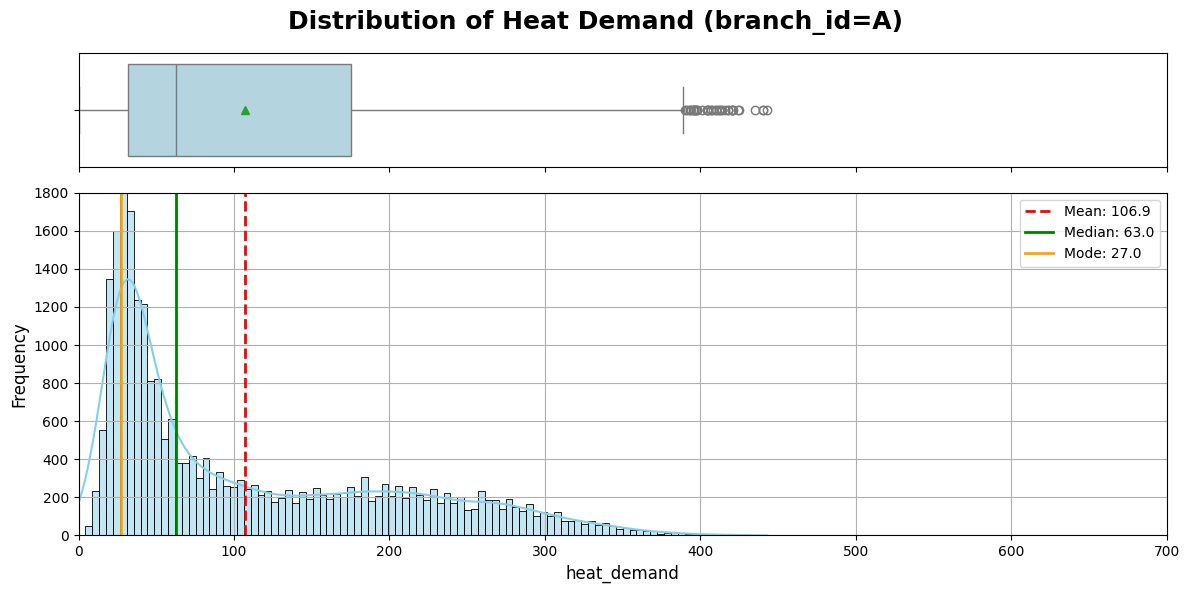

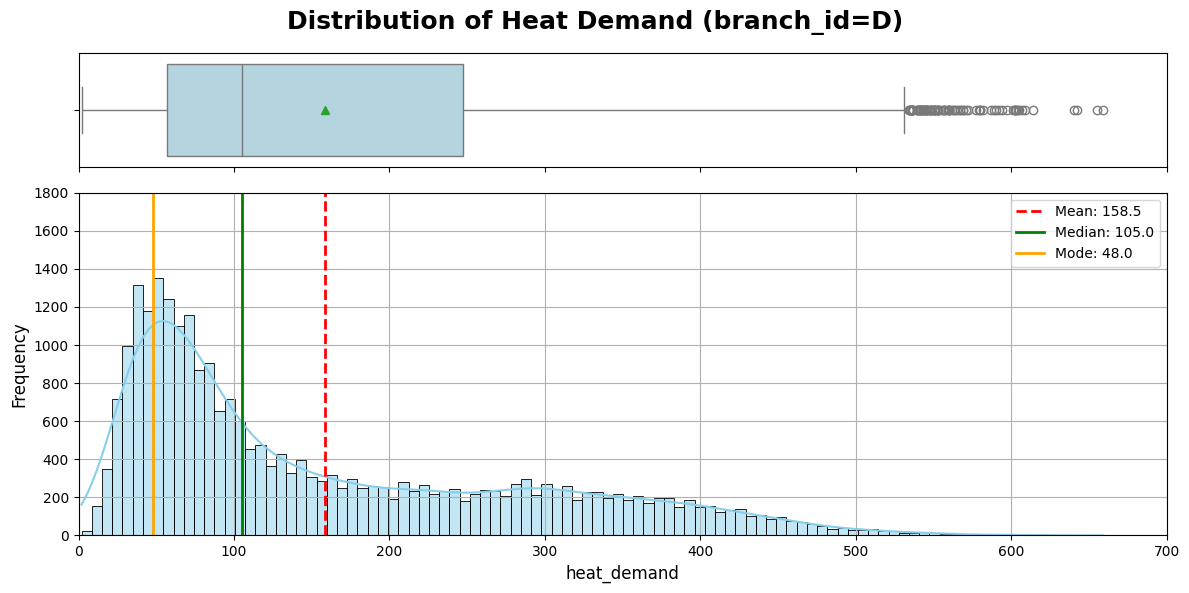

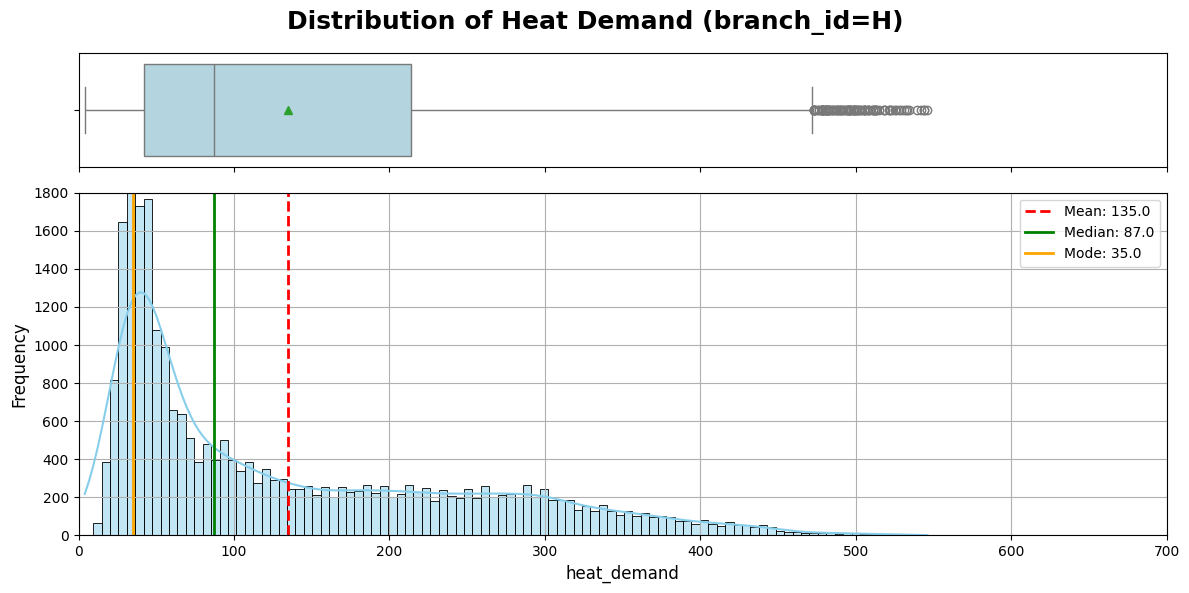

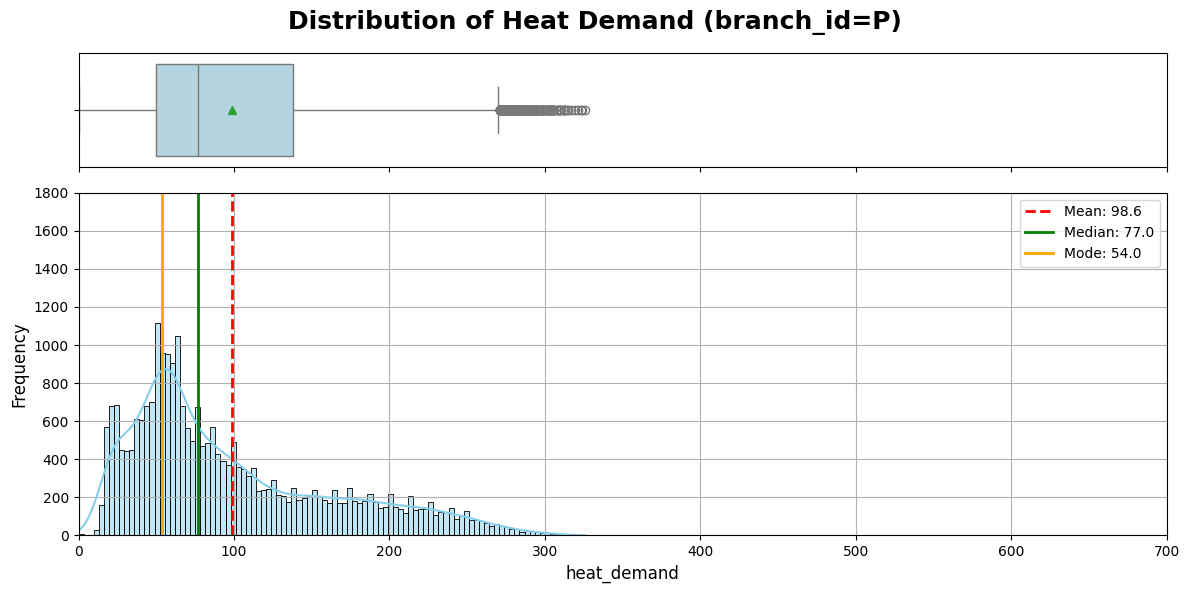

In [100]:
# branch_id별로 분포 시각화
for branch in df_train_cluster2['branch_id'].unique():
    temp_df = df_train_cluster2[df_train_cluster2['branch_id'] == branch]
    plot_heat_demand_distribution(
        temp_df,
        column_name='heat_demand',
        title=f'Distribution of Heat Demand (branch_id={branch})'
    )


- 이상치 파악

In [101]:
def find_outliers(df, column='heat_demand', threshold=350, branch_id=None):
    """
    데이터프레임에서 특정 브랜치의 이상치를 탐색하는 함수
    
    Parameters:
    - df: 분석 대상 데이터프레임
    - column: 분석 컬럼 (기본값: heat_demand)
    - threshold: 이상치 기준값 (기본값: 350)
    - branch_id: 특정 브랜치 선택 (기본값: 전체 브랜치)
    
    Returns:
    - 이상치 데이터프레임 (지정 컬럼 기준 내림차순 정렬)
    """
    # 브랜치 선택
    if branch_id is not None:
        df = df[df['branch_id'] == branch_id]
    
    # 이상치 필터링 및 정렬
    outliers = df[df[column] >= threshold]
    return outliers.sort_values(column, ascending=False)


In [102]:
# 이상치 확인 -> 브랜치 A
find_outliers(df_train_cluster2[['tm','ta','ta_chi','branch_id','heat_demand']], branch_id= 'A', threshold=420)


,tm,ta,ta_chi,branch_id,heat_demand
680,2021-01-29 09:00:00,-11.4,-16.0,A,443.0
679,2021-01-29 08:00:00,-11.6,-16.9,A,440.0
26045,2023-12-22 08:00:00,-15.1,-19.7,A,440.0
681,2021-01-29 10:00:00,-10.2,-15.2,A,435.0
26044,2023-12-22 07:00:00,-15.0,-19.7,A,425.0
176,2021-01-08 09:00:00,-18.4,-17.4,A,424.0
151,2021-01-07 08:00:00,-16.8,-23.9,A,421.0
164,2021-01-07 21:00:00,-15.3,-20.5,A,420.0
175,2021-01-08 08:00:00,-18.8,-22.8,A,420.0
26046,2023-12-22 09:00:00,-14.9,-18.9,A,420.0


- 많이 추울 때 확실히 heat_demand가 오른다!

### 일별로 온도차가 크면(갑자기 10도가 떨어진다) 열수요가 확 늘어나지 않을까?
- 겨울철에는 최저기온
- 여름철에는 최고기온 차이를 보면 되려나?!
- 여름의 열대야?! 
- 아니면 겨울의 최고기온이 낮으면 최저기온도 낮을거니까?! 둘 다 봐야하나?!

=> 다 보자. 최고기온 차이, 최고끼리의 차이, 최저끼리의 차이, 그리고 일교차까지 다!!

In [205]:
agg_df  = df_train_cluster2[df_train_cluster2['branch_id']=='A'].groupby('date')['ta'].agg(['mean', 'max', 'min']).rename(
    columns={
        'mean': 'ta_mean',
        'max': 'ta_max',
        'min': 'ta_min'
    }
)

# 변화량(절대값 차이)
agg_df['ta_mean_diff'] = agg_df['ta_mean'].diff()
agg_df['ta_max_diff'] = agg_df['ta_max'].diff()
agg_df['ta_min_diff'] = agg_df['ta_min'].diff()

# 변화율(퍼센트 변화)
agg_df['ta_mean_pct_change'] = agg_df['ta_mean'].pct_change()
agg_df['ta_max_pct_change'] = agg_df['ta_max'].pct_change()
agg_df['ta_min_pct_change'] = agg_df['ta_min'].pct_change()

In [206]:
agg_df

,ta_mean,ta_max,ta_min,ta_mean_diff,ta_max_diff,ta_min_diff,ta_mean_pct_change,ta_max_pct_change,ta_min_pct_change
date,,,,,,,,,
2021-01-01,-4.656522,0.5,-10.2,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,-5.400000,-1.9,-9.3,-0.743478,-2.4,0.9,0.159664,-4.800000,-0.088235
2021-01-03,-6.220833,-2.7,-9.7,-0.820833,-0.8,-0.4,0.152006,0.421053,0.043011
2021-01-04,-4.166667,-0.4,-8.2,2.054167,2.3,1.5,-0.330208,-0.851852,-0.154639
2021-01-05,-5.320833,-3.0,-9.8,-1.154167,-2.6,-1.6,0.277000,6.500000,0.195122
...,...,...,...,...,...,...,...,...,...
2023-12-27,1.120833,5.8,-2.7,-0.091667,0.1,-0.6,-0.075601,0.017544,0.285714
2023-12-28,0.620833,4.5,-2.1,-0.500000,-1.3,0.6,-0.446097,-0.224138,-0.222222
2023-12-29,1.212500,4.0,-1.0,0.591667,-0.5,1.1,0.953020,-0.111111,-0.523810


In [207]:
agg_df['date'] = agg_df.index
agg_df = agg_df.reset_index(drop=True)

In [209]:
# merge 진행
merged_df = pd.merge(
    df_train_cluster2,
    agg_df,
    on='date',
    how='left'
)

merged_df['ta_max-min'] = merged_df['ta_max'] - merged_df['ta_min']

In [210]:
# inf, -inf 개수 확인
print(np.isinf(merged_df.select_dtypes(include=[np.number])).sum())


ta                     0
wd                     0
ws                     0
rn_day                 0
rn_hr1                 0
hm                     0
si                     0
ta_chi                 0
heat_demand            0
year                   0
quarter                0
month                  0
day                    0
hour                   0
day_of_week            0
weekofyear             0
hour_group             0
ta_mean                0
ta_max                 0
ta_min                 0
ta_mean_diff           0
ta_max_diff            0
ta_min_diff            0
ta_mean_pct_change     0
ta_max_pct_change      0
ta_min_pct_change     96
ta_max-min             0
dtype: Int64


In [211]:
merged_df.corr(numeric_only=True)['heat_demand'].sort_values(ascending=False)

heat_demand           1.000000
wd                    0.162263
hour_group            0.044682
hour                  0.044414
ta_min_pct_change     0.011000
ta_max-min            0.010553
ta_max_diff           0.006272
day                   0.004958
ta_max_pct_change    -0.004252
ta_mean_diff         -0.007834
ws                   -0.009007
year                 -0.009193
ta_min_diff          -0.011542
day_of_week          -0.022247
ta_mean_pct_change   -0.031431
rn_hr1               -0.074418
rn_day               -0.107147
si                   -0.137929
weekofyear           -0.199135
month                -0.235967
quarter              -0.246101
hm                   -0.262091
ta                   -0.833311
ta_chi               -0.841420
ta_min               -0.847130
ta_max               -0.855244
ta_mean              -0.859190
Name: heat_demand, dtype: float64

In [160]:
merged_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day,hour,day_of_week,weekofyear,hour_group,mean,max,min,mean_diff,max_diff,min_diff,mean_pct_change,max_pct_change,min_pct_change,max-min
ta,1.000000,-0.140137,0.056788,0.115358,0.071108,0.154649,0.314191,0.993075,-0.833311,0.030424,0.211025,0.204085,-0.011400,0.135774,0.000459,0.169121,0.136722,0.950043,0.936983,0.942645,0.092730,0.053872,0.086816,0.042887,0.004198,-0.000314,-0.059775
wd,-0.140137,1.000000,-0.046796,-0.025252,-0.030753,-0.081020,-0.019002,-0.160087,0.162263,-0.002019,-0.027940,-0.027758,-0.004670,0.031456,0.004869,-0.021585,0.031554,-0.165952,-0.158658,-0.168653,-0.086172,-0.038242,-0.105870,-0.017873,0.012593,0.000883,0.042246
ws,0.056788,-0.046796,1.000000,0.060819,0.061118,-0.347236,0.353981,0.018171,-0.009007,-0.017790,-0.077368,-0.069603,-0.005093,0.183075,-0.011921,-0.072945,0.184266,-0.070574,-0.083148,-0.066112,-0.199953,-0.174334,-0.162250,-0.034771,-0.024848,0.025484,-0.060072
rn_day,0.115358,-0.025252,0.060819,1.000000,0.446930,0.233637,-0.069151,0.134271,-0.107147,0.040444,0.040656,0.039831,-0.003088,0.088651,-0.029032,0.035906,0.089815,0.125989,0.088293,0.149649,-0.108464,-0.108043,-0.074396,0.000227,-0.008388,-0.003174,-0.230573
rn_hr1,0.071108,-0.030753,0.061118,0.446930,1.000000,0.177923,-0.065303,0.086352,-0.074418,0.021479,0.027545,0.026901,-0.004546,0.002319,-0.021516,0.024235,0.002278,0.083659,0.059386,0.098725,-0.071127,-0.080028,-0.041337,-0.000104,-0.005715,-0.002027,-0.147927
hm,0.154649,-0.081020,-0.347236,0.233637,0.177923,1.000000,-0.496618,0.212043,-0.262091,0.027379,0.250998,0.247679,0.026404,-0.272024,-0.007905,0.238452,-0.273962,0.334080,0.276719,0.375007,-0.021612,-0.058757,0.018488,0.030653,-0.018401,-0.015157,-0.375484
si,0.314191,-0.019002,0.353981,-0.069151,-0.065303,-0.496618,1.000000,0.274789,-0.137929,0.044146,-0.052907,-0.053014,-0.013508,0.151263,0.004395,-0.058648,0.152456,0.124046,0.154594,0.099617,0.058750,0.103129,0.001520,0.003136,0.014631,0.004989,0.197008
ta_chi,0.993075,-0.160087,0.018171,0.134271,0.086352,0.212043,0.274789,1.000000,-0.841420,0.013631,0.207832,0.202900,-0.004217,0.117695,0.001459,0.170036,0.118524,0.958576,0.941375,0.954615,0.092447,0.053672,0.087534,0.043119,0.004506,-0.002646,-0.094094
heat_demand,-0.833311,0.162263,-0.009007,-0.107147,-0.074418,-0.262091,-0.137929,-0.841420,1.000000,-0.009193,-0.246101,-0.235967,0.004958,0.044414,-0.022247,-0.199135,0.044682,-0.859190,-0.855244,-0.847130,-0.007834,0.006272,-0.011542,-0.031431,-0.004252,0.011000,0.010553
year,0.030424,-0.002019,-0.017790,0.040444,0.021479,0.027379,0.044146,0.013631,-0.009193,1.000000,-0.000047,-0.000066,-0.000107,-0.000117,0.001142,-0.000134,-0.000109,0.008101,0.005751,0.012371,0.002383,0.002305,0.001756,0.026117,-0.023223,-0.040558,-0.024901


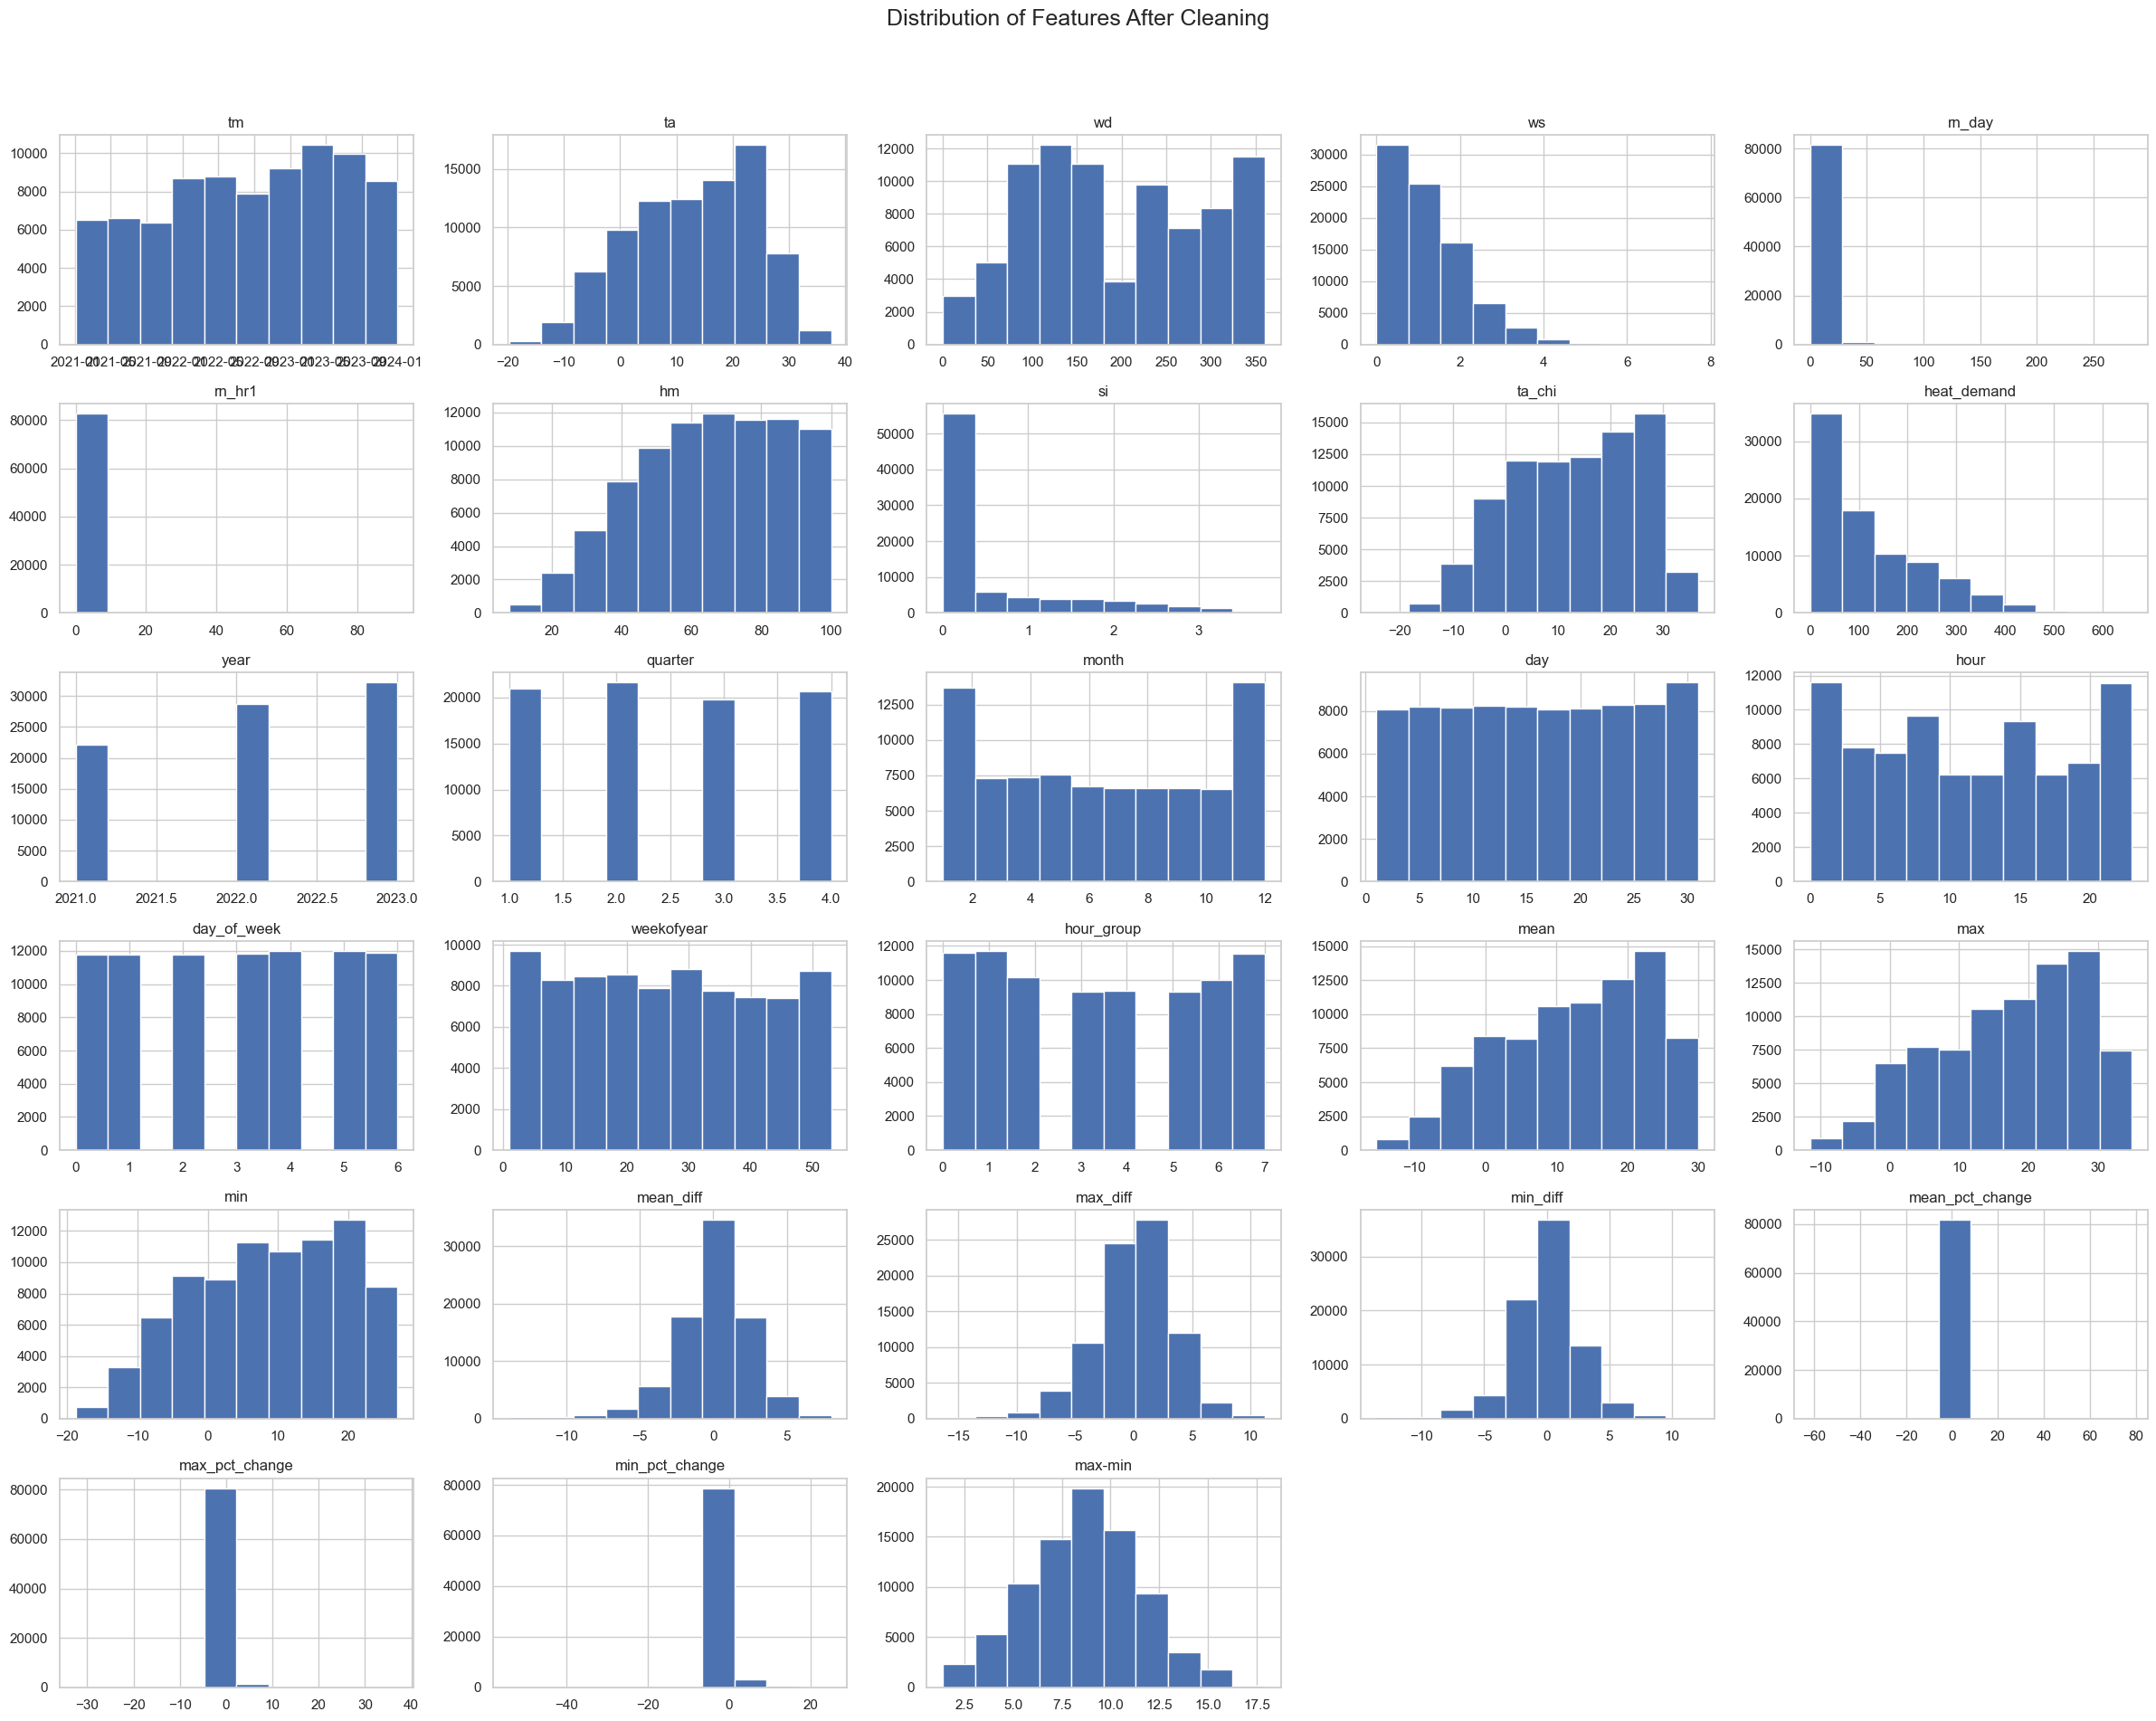

In [177]:
# inf, -inf를 NaN으로 변환
df_clean = merged_df.replace([np.inf, -np.inf], np.nan)
# NaN(결측치) 제거
df_clean = df_clean.dropna()
# 히스토그램 그리기
df_clean.drop('branch_id', axis=1).hist(figsize=(24, 20))
plt.suptitle('Distribution of Features After Cleaning', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [213]:
merged_df[['ta_mean_pct_change', 'ta_max_pct_change', 'ta_min_pct_change']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105112 entries, 0 to 105111
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ta_mean_pct_change  105020 non-null  float64
 1   ta_max_pct_change   105020 non-null  float64
 2   ta_min_pct_change   105020 non-null  float64
dtypes: float64(3)
memory usage: 2.4 MB


In [214]:
merged_df[['ta_mean_pct_change', 'ta_max_pct_change', 'ta_min_pct_change']].describe()

c:\Users\smlee\Desktop\python\.venv2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,ta_mean_pct_change,ta_max_pct_change,ta_min_pct_change
count,105020.000000,105020.000000,1.050200e+05
mean,-0.075157,0.009120,-inf
std,4.970974,2.082186,NaN
min,-61.600000,-32.500000,-inf
25%,-0.111732,-0.120755,-1.736111e-01
50%,0.002395,0.004082,-1.209677e-02
75%,0.099323,0.121795,1.214286e-01
max,78.000000,37.000000,2.500000e+01


In [215]:
heat_demand_agg = df_train_cluster2[df_train_cluster2['branch_id'] == 'A'] \
    .groupby('date')['heat_demand'].agg(['mean', 'max', 'min']).rename(
        columns={
            'mean': 'heat_demand_mean',
            'max': 'heat_demand_max',
            'min': 'heat_demand_min'
        }
    )
pct_change_df = agg_df[['ta_mean_pct_change', 'ta_max_pct_change', 'ta_min_pct_change','date']]
merged = pd.merge(heat_demand_agg, pct_change_df, on='date')
result = merged.dropna().sort_values(by='ta_mean_pct_change', ascending=True)


In [216]:
result.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

,heat_demand_mean,heat_demand_max,heat_demand_min,ta_mean_pct_change,ta_max_pct_change,ta_min_pct_change
heat_demand_mean,1.000000,0.992378,0.990692,-0.036614,-0.004807,0.014025
heat_demand_max,0.992378,1.000000,0.972605,-0.033940,0.000807,0.010225
heat_demand_min,0.990692,0.972605,1.000000,-0.037207,-0.005760,0.015859
ta_mean_pct_change,-0.036614,-0.033940,-0.037207,1.000000,0.039496,-0.019642
ta_max_pct_change,-0.004807,0.000807,-0.005760,0.039496,1.000000,0.001218
ta_min_pct_change,0.014025,0.010225,0.015859,-0.019642,0.001218,1.000000


In [217]:
result

,date,heat_demand_mean,heat_demand_max,heat_demand_min,ta_mean_pct_change,ta_max_pct_change,ta_min_pct_change
712,2022-12-14,283.541667,339.0,244.0,-61.600000,-3.269231,0.885246
358,2021-12-25,286.625000,351.0,251.0,-56.580000,-3.925926,1.042254
786,2023-02-26,180.916667,233.0,128.0,-53.833333,0.711111,0.027778
375,2022-01-11,294.458333,364.0,214.0,-42.024390,-1.083333,2.714286
1052,2023-11-19,165.750000,218.0,119.0,-40.878788,1.844444,-0.756098
...,...,...,...,...,...,...,...
720,2022-12-22,301.000000,372.0,244.0,15.899083,-2.375000,3.384615
753,2023-01-24,335.375000,383.0,296.0,24.277372,-2.727273,1.661538
50,2021-02-20,190.083333,240.0,144.0,27.826087,0.710843,-1.613333
1067,2023-12-04,208.916667,289.0,149.0,68.625000,0.595745,-0.117647


<Axes: >

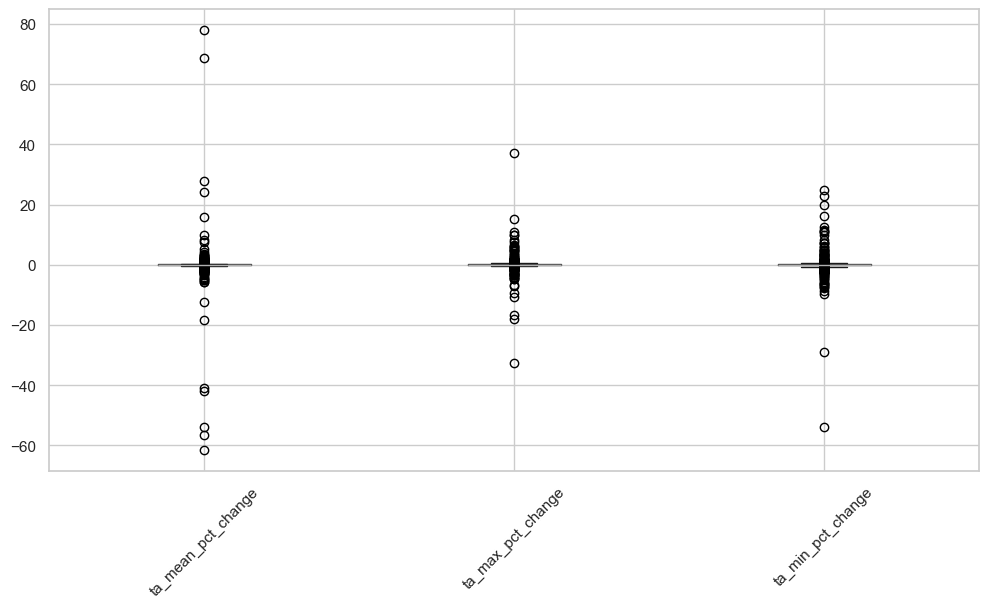

In [250]:
result[['ta_mean_pct_change','ta_max_pct_change','ta_min_pct_change']].boxplot(figsize=(12, 6), rot=45)

In [228]:
df_train_cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105112 entries, 0 to 420444
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           105112 non-null  datetime64[ns]
 1   branch_id    105112 non-null  object        
 2   ta           101226 non-null  float64       
 3   wd           98176 non-null   float64       
 4   ws           98948 non-null   float64       
 5   rn_day       99552 non-null   float64       
 6   rn_hr1       99424 non-null   float64       
 7   hm           97099 non-null   float64       
 8   si           95238 non-null   float64       
 9   ta_chi       105111 non-null  float64       
 10  heat_demand  105112 non-null  float64       
 11  year         105112 non-null  int32         
 12  quarter      105112 non-null  int32         
 13  month        105112 non-null  int32         
 14  day          105112 non-null  int32         
 15  hour         105112 non-null  int32    

In [237]:
start = pd.to_datetime('2022-12-14')
end = pd.to_datetime('2022-12-15')
df_train_cluster2[
    (df_train_cluster2['branch_id'] == 'A') &
    (df_train_cluster2['tm'] >= start) &
    (df_train_cluster2['tm'] < end)
]


,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,quarter,month,day,hour,date,day_of_week,season,is_weekend,weekofyear,hour_group
17086,2022-12-14 00:00:00,A,-7.1,103.6,4.4,0.0,0.0,54.3,0.00,-6.2,...,4,12,14,0,2022-12-14,2,Winter,Weekday,50,0
17087,2022-12-14 01:00:00,A,-8.1,99.3,4.4,0.0,0.0,42.3,0.00,-9.7,...,4,12,14,1,2022-12-14,2,Winter,Weekday,50,0
17088,2022-12-14 02:00:00,A,-9.0,94.7,3.6,0.0,0.0,43.4,0.00,-11.8,...,4,12,14,2,2022-12-14,2,Winter,Weekday,50,0
17089,2022-12-14 03:00:00,A,-9.7,109.3,3.3,0.0,0.0,42.6,0.00,-8.8,...,4,12,14,3,2022-12-14,2,Winter,Weekday,50,1
17090,2022-12-14 04:00:00,A,-10.3,107.9,2.9,0.0,0.0,43.0,0.00,-9.3,...,4,12,14,4,2022-12-14,2,Winter,Weekday,50,1
17091,2022-12-14 05:00:00,A,-10.7,104.6,2.2,0.0,0.0,43.1,0.00,-9.9,...,4,12,14,5,2022-12-14,2,Winter,Weekday,50,1
17092,2022-12-14 06:00:00,A,-10.9,105.7,2.8,0.0,0.0,42.5,0.00,-10.0,...,4,12,14,6,2022-12-14,2,Winter,Weekday,50,2
17093,2022-12-14 07:00:00,A,-11.2,116.9,3.1,0.0,0.0,44.5,0.00,-10.3,...,4,12,14,7,2022-12-14,2,Winter,Weekday,50,2
17094,2022-12-14 08:00:00,A,-11.5,109.0,2.9,0.0,0.0,42.3,0.01,-10.6,...,4,12,14,8,2022-12-14,2,Winter,Weekday,50,2
17095,2022-12-14 09:00:00,A,-11.3,106.6,3.4,0.0,0.0,42.5,0.38,-10.0,...,4,12,14,9,2022-12-14,2,Winter,Weekday,50,3


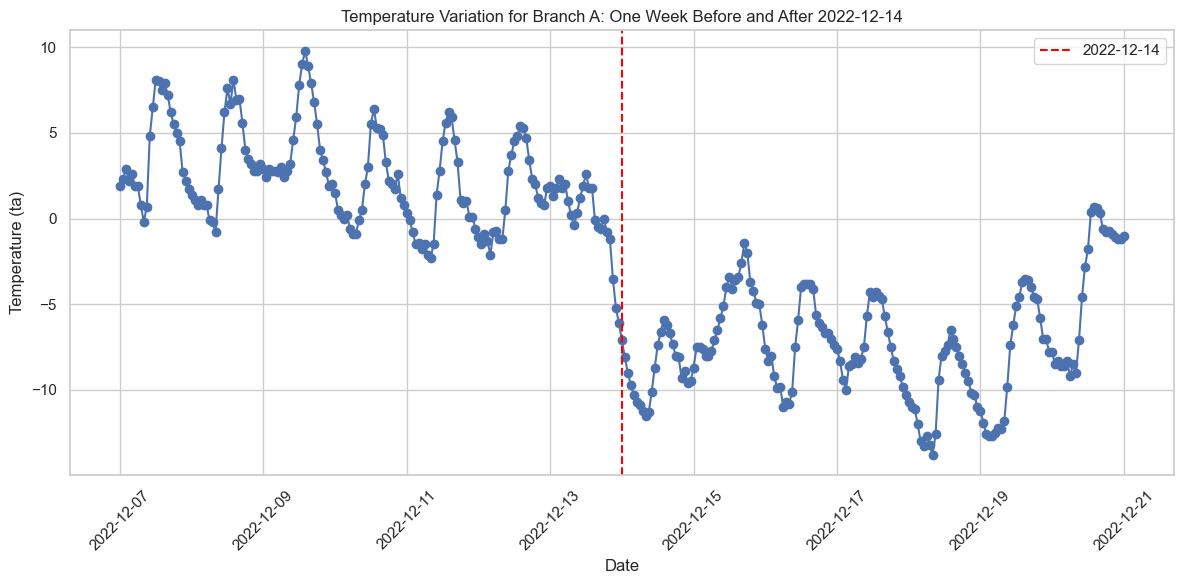

In [247]:
# 날짜 범위 설정
start_date = '2022-12-07'
end_date = '2022-12-21'

# Branch A, 해당 날짜 범위 필터링
filtered_df = df_train_cluster2[
    (df_train_cluster2['branch_id'] == 'A') &
    (df_train_cluster2['tm'] >= start_date) &
    (df_train_cluster2['tm'] <= end_date)
]

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['tm'], filtered_df['ta'], marker='o')
plt.axvline(pd.Timestamp('2022-12-14'), color='red', linestyle='--', label='2022-12-14')
plt.title('Temperature Variation for Branch A: One Week Before and After 2022-12-14')
plt.xlabel('Date')
plt.ylabel('Temperature (ta)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

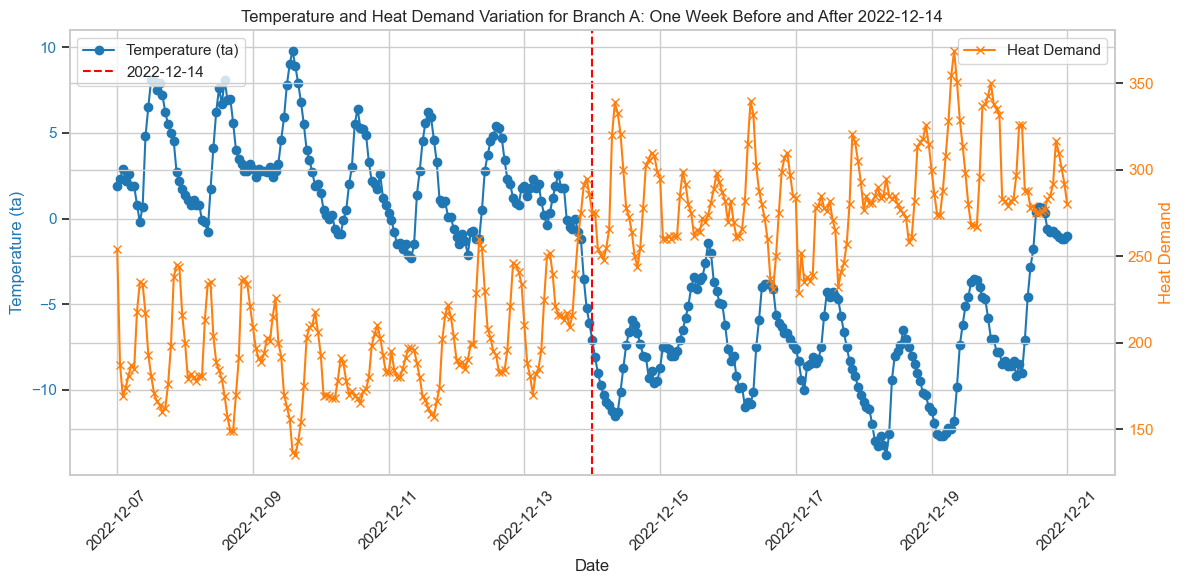

In [248]:
start_date = '2022-12-07'
end_date = '2022-12-21'

filtered_df = df_train_cluster2[
    (df_train_cluster2['branch_id'] == 'A') &
    (df_train_cluster2['tm'] >= start_date) &
    (df_train_cluster2['tm'] <= end_date)
].copy()

filtered_df['tm'] = pd.to_datetime(filtered_df['tm'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# 기온(ta) 선 그래프
ax1.plot(filtered_df['tm'], filtered_df['ta'], color='tab:blue', marker='o', label='Temperature (ta)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (ta)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=45)

# 열수요(heat_demand) 선 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_df['tm'], filtered_df['heat_demand'], color='tab:orange', marker='x', label='Heat Demand')
ax2.set_ylabel('Heat Demand', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 기준일 표시
ax1.axvline(pd.Timestamp('2022-12-14'), color='red', linestyle='--', label='2022-12-14')

# 타이틀 및 범례
plt.title('Temperature and Heat Demand Variation for Branch A: One Week Before and After 2022-12-14')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


- 일별 변화량이 아니라 시간당, 아니면 뭐 3시간당 5시간당 7시간당 변화량으로 봐도 되겠다!
- shift를 적용해서 correlation을 그렸을 때 유의미한 결과가 나올 수 있겠다!

# lag

In [342]:
def make_shift_features(df, value_col, time_col='tm', shifts=[1, 3, 5, 7, 24], prefix='ta'):
    """
    시간 단위로 특정 컬럼의 변화량(diff)과 변화율(pct_change)을 계산합니다.

    Parameters:
    - df: 원본 DataFrame
    - value_col: 변화량을 구할 대상 컬럼명 (예: 'ta')
    - time_col: 시간 컬럼명 (기본값: 'datetime')
    - shifts: 시차 리스트 (기본: [1, 3, 5, 7])
    - prefix: 결과 컬럼의 prefix

    Returns:
    - df: 새로운 피처가 추가된 DataFrame
    """
    df = df.sort_values(time_col).copy()
    
    for shift in shifts:
        diff_col = f'{prefix}_diff_{shift}h'
        pct_col = f'{prefix}_pct_{shift}h'
        
        df[diff_col] = df[value_col] - df[value_col].shift(shift)
        df[pct_col] = df[value_col].pct_change(periods=shift, fill_method=None)

    
    return df


In [343]:
def add_shifted_features(df, exclude_cols=None, max_shift=23):
    """
    지정한 컬럼을 제외한 수치형 변수들에 대해 1~max_shift까지 shift된 컬럼을 생성합니다.
    성능 향상을 위해 pd.concat을 사용합니다.
    """
    df = df.copy()
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include='number').columns
    target_cols = [col for col in numeric_cols if col not in exclude_cols]

    shifted_cols = []  # 여기에 모든 shift 결과를 저장

    for col in target_cols:
        for shift in range(1, max_shift + 1):
            shifted = df[col].shift(shift).rename(f"{col}_shift_{shift}h")
            shifted_cols.append(shifted)

    # 기존 df + shift된 것들 concat
    df_shifted = pd.concat([df] + shifted_cols, axis=1)

    return df_shifted


In [344]:
df_train_cluster2['branch_id'].unique()

array(['A', 'D', 'H', 'P'], dtype=object)

In [345]:
branch_dfs = {}  # branch_id를 key로, df를 value로 저장할 dict

for branch in df_train_cluster2['branch_id'].unique():
    df_branch = df_train_cluster2[df_train_cluster2['branch_id'] == branch].copy()

    # 원하는 피처 엔지니어링 수행
    df_branch = make_shift_features(df_branch, value_col='ta', time_col='tm', shifts=[1, 3, 5, 7], prefix='ta')
    df_branch = add_shifted_features(df_branch, exclude_cols=['heat_demand'], max_shift=23)

    # dict에 저장
    branch_dfs[branch] = df_branch


In [346]:
corr_A = branch_dfs['A'].corr(numeric_only=True)['heat_demand'].sort_values(ascending=True)
corr_D = branch_dfs['D'].corr(numeric_only=True)['heat_demand'].sort_values(ascending=True)
corr_H = branch_dfs['H'].corr(numeric_only=True)['heat_demand'].sort_values(ascending=True)
corr_P = branch_dfs['P'].corr(numeric_only=True)['heat_demand'].sort_values(ascending=True)

In [347]:
print(f"A: {corr_A.head(30).index}")
print(f"D: {corr_D.head(30).index}")
print(f"H: {corr_H.head(30).index}")
print(f"P: {corr_P.head(30).index}")


A: Index(['ta_chi_shift_1h', 'ta_chi', 'ta_chi_shift_2h', 'ta_shift_1h', 'ta',
       'ta_shift_2h', 'ta_chi_shift_3h', 'ta_shift_3h', 'ta_chi_shift_4h',
       'ta_chi_shift_23h', 'ta_chi_shift_14h', 'ta_chi_shift_13h',
       'ta_chi_shift_22h', 'ta_chi_shift_15h', 'ta_chi_shift_12h',
       'ta_shift_4h', 'ta_chi_shift_16h', 'ta_chi_shift_21h',
       'ta_chi_shift_5h', 'ta_shift_23h', 'ta_shift_14h', 'ta_chi_shift_17h',
       'ta_chi_shift_11h', 'ta_shift_13h', 'ta_chi_shift_20h', 'ta_shift_15h',
       'ta_chi_shift_18h', 'ta_chi_shift_19h', 'ta_shift_22h', 'ta_shift_12h'],
      dtype='object')
D: Index(['ta_shift_2h', 'ta_shift_1h', 'ta_chi_shift_2h', 'ta_shift_3h',
       'ta_chi_shift_3h', 'ta_chi_shift_1h', 'ta', 'ta_shift_4h',
       'ta_chi_shift_4h', 'ta_chi', 'ta_shift_5h', 'ta_chi_shift_5h',
       'ta_chi_shift_6h', 'ta_shift_6h', 'ta_shift_23h', 'ta_chi_shift_23h',
       'ta_chi_shift_13h', 'ta_chi_shift_14h', 'ta_shift_13h', 'ta_shift_14h',
       'ta_chi_shift_7h',

In [348]:
# 각 브랜치 상관계수 시리즈를 데이터프레임으로 변환
df_corr = pd.DataFrame({
    'A': corr_A,
    'D': corr_D,
    'H': corr_H,
    'P': corr_P
})

# 상관계수 절대값 기준으로 정렬
df_corr['mean_abs_corr'] = df_corr.abs().mean(axis=1)
df_corr = df_corr.sort_values(by='mean_abs_corr', ascending=False)

print(df_corr)


                        A         D         H         P  mean_abs_corr
heat_demand      1.000000  1.000000  1.000000  1.000000       1.000000
ta_chi_shift_1h -0.915819 -0.895261 -0.897150 -0.801403       0.877408
ta_chi          -0.915702 -0.890210 -0.901657 -0.800946       0.877128
ta_shift_1h     -0.912081 -0.897451 -0.894270 -0.797462       0.875316
ta              -0.911505 -0.892731 -0.898662 -0.797264       0.875041
...                   ...       ...       ...       ...            ...
day_shift_13h    0.001642  0.003212  0.003874  0.000107       0.002209
day_shift_14h    0.001637  0.003101  0.003876  0.000099       0.002178
day_shift_17h    0.001592  0.002821  0.004026  0.000227       0.002166
day_shift_15h    0.001661  0.002947  0.003881  0.000118       0.002152
day_shift_16h    0.001611  0.002807  0.003911  0.000161       0.002123

[577 rows x 5 columns]


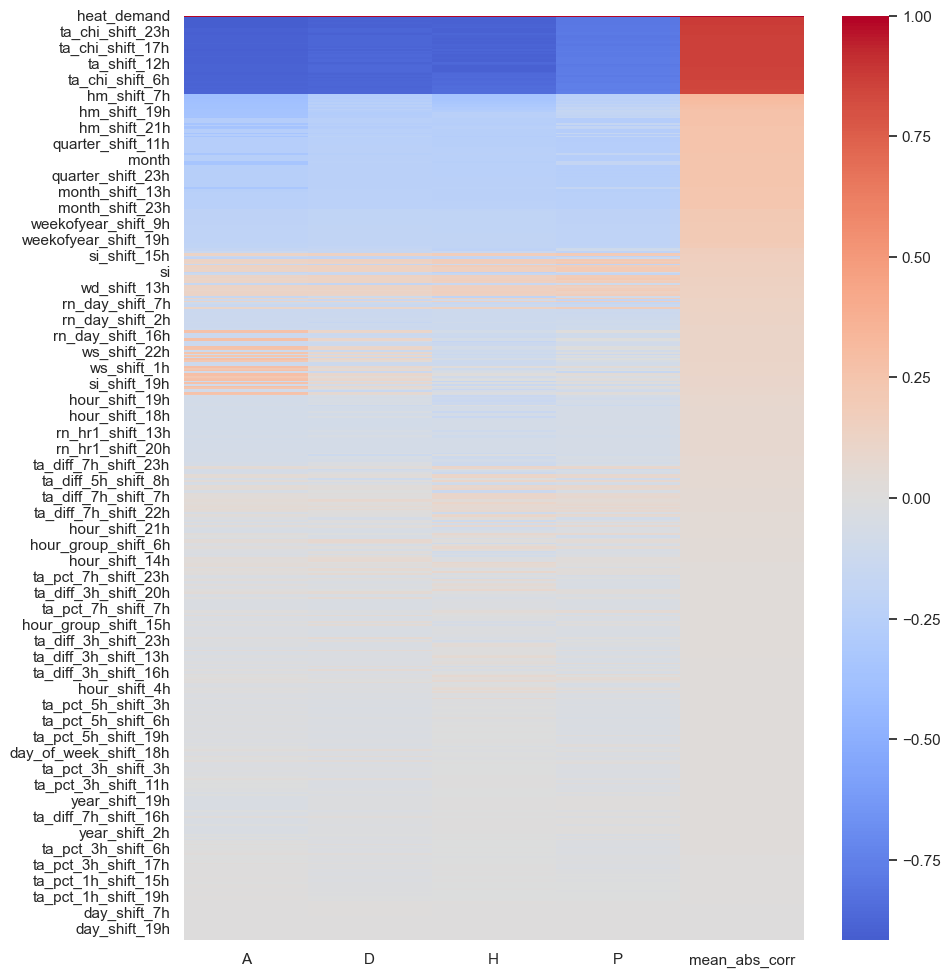

In [349]:
plt.figure(figsize=(10, 12))
sns.heatmap((df_corr), annot=False, cmap='coolwarm', center=0)
plt.show()


In [350]:
df_corr['max_diff'] = df_corr.max(axis=1) - df_corr.min(axis=1)
df_corr = df_corr.sort_values(by='max_diff', ascending=False)
print(df_corr.head(10))  # 차이가 큰 상위 10개 변수


                         A         D         H         P  mean_abs_corr  \
ta_chi_shift_1h  -0.915819 -0.895261 -0.897150 -0.801403       0.877408   
ta_chi           -0.915702 -0.890210 -0.901657 -0.800946       0.877128   
ta_chi_shift_2h  -0.913177 -0.897221 -0.889869 -0.797360       0.874407   
ta_shift_1h      -0.912081 -0.897451 -0.894270 -0.797462       0.875316   
ta               -0.911505 -0.892731 -0.898662 -0.797264       0.875041   
ta_shift_2h      -0.909588 -0.898879 -0.886581 -0.793485       0.872133   
ta_chi_shift_3h  -0.908366 -0.895892 -0.880766 -0.789954       0.868745   
ta_shift_3h      -0.904587 -0.896951 -0.876422 -0.786385       0.866086   
ta_chi_shift_23h -0.902167 -0.879730 -0.896705 -0.786690       0.866323   
ta_chi_shift_14h -0.900626 -0.877834 -0.894586 -0.793615       0.866665   

                  max_diff  
ta_chi_shift_1h   1.793227  
ta_chi            1.792830  
ta_chi_shift_2h   1.787583  
ta_shift_1h       1.787397  
ta                1.786545  


In [351]:
n = 50

# 각 branch별 상관계수 절대값 기준 상위 n개 변수 이름 추출
top_A = corr_A.abs().sort_values(ascending=False).head(n).index
top_D = corr_D.abs().sort_values(ascending=False).head(n).index
top_H = corr_H.abs().sort_values(ascending=False).head(n).index
top_P = corr_P.abs().sort_values(ascending=False).head(n).index

# 공통 변수들
common_vars = set(top_A) & set(top_D) & set(top_H) & set(top_P)

print("공통적으로 상관계수 절대값이 큰 변수들:", common_vars)
print("공통 변수 개수:", len(common_vars))


공통적으로 상관계수 절대값이 큰 변수들: {'ta_chi_shift_12h', 'ta_shift_6h', 'ta_chi_shift_10h', 'ta_shift_9h', 'ta_chi', 'ta_shift_19h', 'ta_chi_shift_20h', 'ta_shift_23h', 'ta_shift_8h', 'ta_shift_2h', 'ta_shift_22h', 'ta_shift_20h', 'ta_shift_1h', 'ta_chi_shift_7h', 'ta_chi_shift_17h', 'ta_shift_21h', 'ta_chi_shift_22h', 'ta_shift_10h', 'ta_chi_shift_9h', 'ta_shift_15h', 'ta_chi_shift_5h', 'ta_chi_shift_14h', 'ta_shift_12h', 'ta_chi_shift_23h', 'ta_chi_shift_1h', 'ta_shift_3h', 'ta_chi_shift_13h', 'heat_demand', 'ta_shift_14h', 'ta_shift_7h', 'ta_shift_18h', 'ta_shift_13h', 'ta', 'ta_shift_11h', 'ta_chi_shift_18h', 'ta_chi_shift_16h', 'ta_chi_shift_15h', 'ta_shift_5h', 'ta_chi_shift_4h', 'ta_chi_shift_21h', 'ta_chi_shift_11h', 'ta_shift_16h', 'ta_chi_shift_2h', 'ta_chi_shift_19h', 'ta_shift_17h', 'ta_shift_4h', 'ta_chi_shift_3h', 'ta_chi_shift_6h', 'ta_chi_shift_8h'}
공통 변수 개수: 49


In [352]:
sorted(common_vars)

['heat_demand',
 'ta',
 'ta_chi',
 'ta_chi_shift_10h',
 'ta_chi_shift_11h',
 'ta_chi_shift_12h',
 'ta_chi_shift_13h',
 'ta_chi_shift_14h',
 'ta_chi_shift_15h',
 'ta_chi_shift_16h',
 'ta_chi_shift_17h',
 'ta_chi_shift_18h',
 'ta_chi_shift_19h',
 'ta_chi_shift_1h',
 'ta_chi_shift_20h',
 'ta_chi_shift_21h',
 'ta_chi_shift_22h',
 'ta_chi_shift_23h',
 'ta_chi_shift_2h',
 'ta_chi_shift_3h',
 'ta_chi_shift_4h',
 'ta_chi_shift_5h',
 'ta_chi_shift_6h',
 'ta_chi_shift_7h',
 'ta_chi_shift_8h',
 'ta_chi_shift_9h',
 'ta_shift_10h',
 'ta_shift_11h',
 'ta_shift_12h',
 'ta_shift_13h',
 'ta_shift_14h',
 'ta_shift_15h',
 'ta_shift_16h',
 'ta_shift_17h',
 'ta_shift_18h',
 'ta_shift_19h',
 'ta_shift_1h',
 'ta_shift_20h',
 'ta_shift_21h',
 'ta_shift_22h',
 'ta_shift_23h',
 'ta_shift_2h',
 'ta_shift_3h',
 'ta_shift_4h',
 'ta_shift_5h',
 'ta_shift_6h',
 'ta_shift_7h',
 'ta_shift_8h',
 'ta_shift_9h']

In [365]:
n = 150

# 각 branch별 상관계수 절대값 기준 상위 n개 변수 이름 추출
top_A = corr_A.abs().sort_values(ascending=False).head(n).index
top_D = corr_D.abs().sort_values(ascending=False).head(n).index
top_H = corr_H.abs().sort_values(ascending=False).head(n).index
top_P = corr_P.abs().sort_values(ascending=False).head(n).index

# 공통 변수들
common_vars = set(top_A) & set(top_D) & set(top_H) & set(top_P)

common_vars_no_ta = {var for var in common_vars if all(x not in var for x in ['ta', 'quarter', 'month','weekofyear'])}
print("공통 변수 중 'ta'가 포함되지 않은 변수들:", common_vars_no_ta)
print("개수:", len(common_vars_no_ta))


공통 변수 중 'ta'가 포함되지 않은 변수들: {'hm_shift_11h', 'hm_shift_21h', 'hm_shift_5h', 'hm_shift_8h', 'hm_shift_19h', 'hm_shift_2h', 'hm_shift_10h', 'hm_shift_4h', 'hm_shift_3h', 'hm_shift_22h', 'hm_shift_7h', 'hm_shift_18h', 'hm_shift_6h', 'hm_shift_9h', 'hm_shift_20h', 'heat_demand'}
개수: 16


In [383]:
df_corr.loc[list(common_vars_no_ta), :]


,A,D,H,P,mean_abs_corr
hm_shift_11h,-0.374810,-0.272801,-0.314093,-0.194986,0.289173
hm_shift_21h,-0.343989,-0.262589,-0.237818,-0.190088,0.258621
hm_shift_5h,-0.377662,-0.249715,-0.331955,-0.230548,0.297470
hm_shift_8h,-0.395227,-0.276121,-0.353842,-0.239011,0.316050
hm_shift_19h,-0.356506,-0.273533,-0.241902,-0.189603,0.265386
hm_shift_2h,-0.345382,-0.226195,-0.271376,-0.185549,0.257126
hm_shift_10h,-0.384672,-0.276903,-0.332426,-0.213090,0.301773
hm_shift_4h,-0.366093,-0.239019,-0.313056,-0.216822,0.283748
hm_shift_3h,-0.354551,-0.230440,-0.291867,-0.200613,0.269368
hm_shift_22h,-0.334653,-0.250975,-0.235205,-0.184931,0.251441


# 여름 vs 겨울

In [407]:
df_train_cluster2.head(3)

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,quarter,month,day,hour,date,day_of_week,season,is_weekend,weekofyear,hour_group
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,...,1,1,1,1,2021-01-01,4,Winter,Weekday,53,0
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,...,1,1,1,2,2021-01-01,4,Winter,Weekday,53,0
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,...,1,1,1,3,2021-01-01,4,Winter,Weekday,53,1


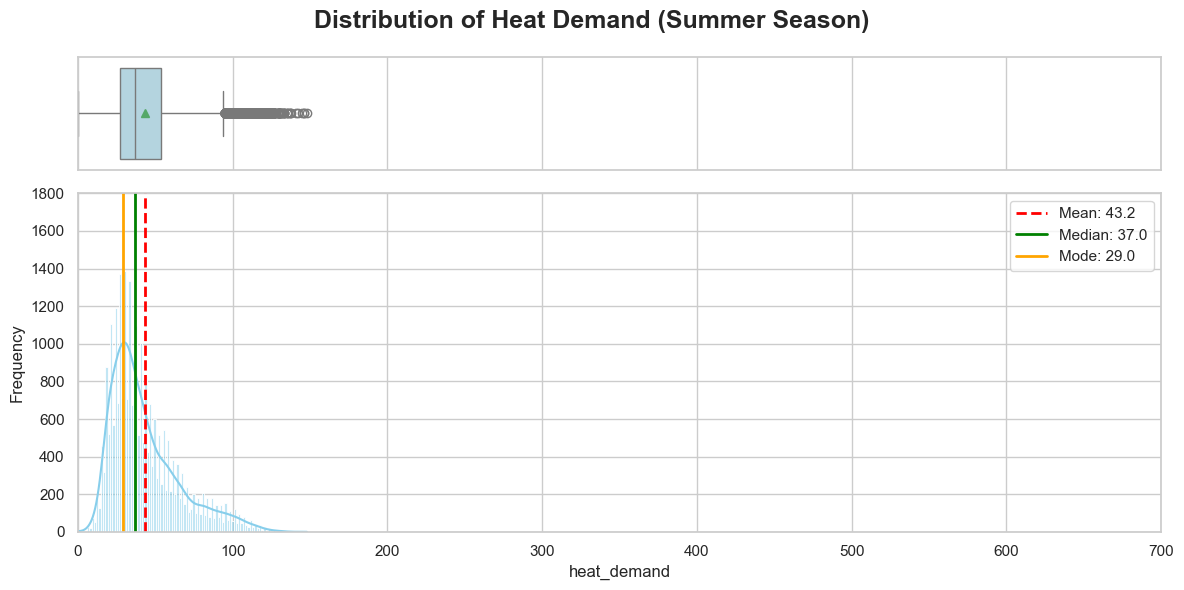

In [408]:
df_train_cluster2_summer = df_train_cluster2[df_train_cluster2['season'] == 'Summer'].copy()
# 여름 시즌의 heat_demand 분포 시각화
plot_heat_demand_distribution(
    df_train_cluster2_summer,
    column_name='heat_demand',
    title='Distribution of Heat Demand (Summer Season)'
)

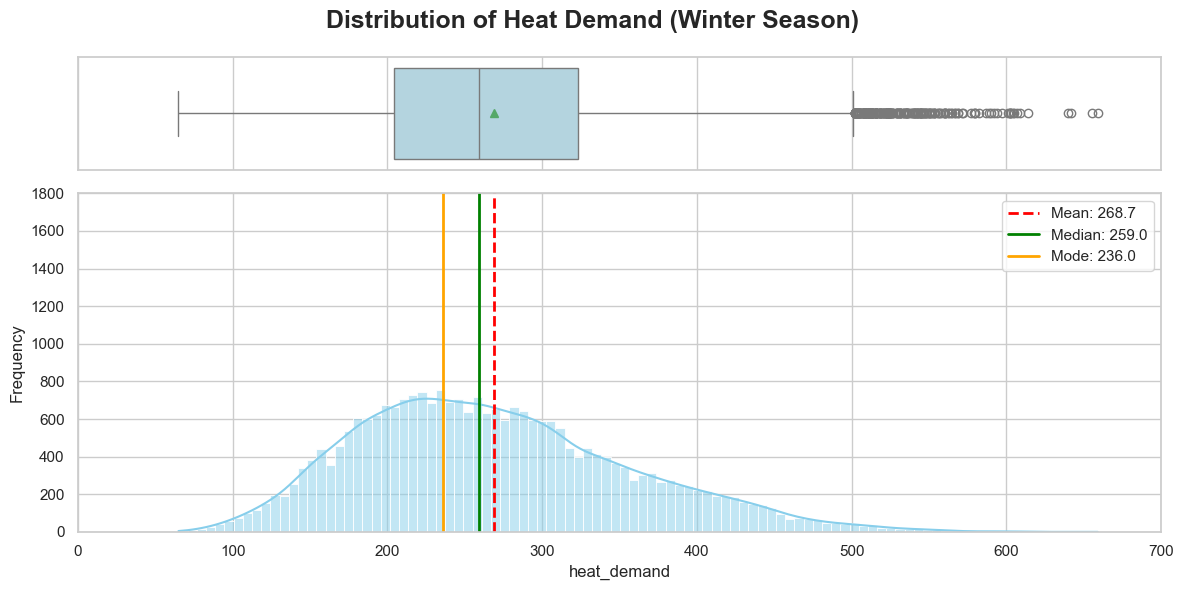

In [409]:
df_train_cluster2_winter = df_train_cluster2[df_train_cluster2['season'] == 'Winter'].copy()
# 겨울 시즌의 heat_demand 분포 시각화
plot_heat_demand_distribution(
    df_train_cluster2_winter,
    column_name='heat_demand',
    title='Distribution of Heat Demand (Winter Season)'
)

Text(0.5, 1.0, 'Hour vs Heat Demand (Summer vs Winter)')

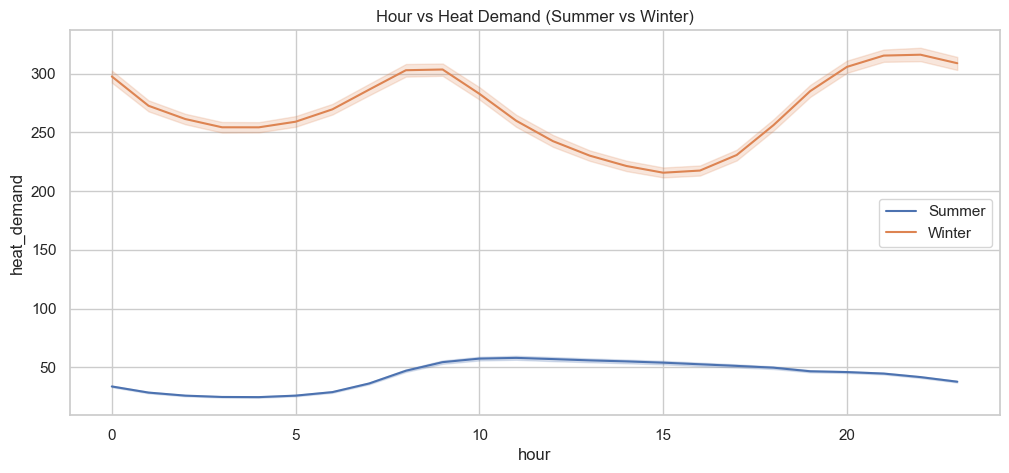

In [410]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_train_cluster2_summer, x='hour', y='heat_demand', label='Summer')
sns.lineplot(data=df_train_cluster2_winter, x='hour', y='heat_demand', label='Winter')
plt.title('Hour vs Heat Demand (Summer vs Winter)')


<Axes: xlabel='month', ylabel='heat_demand'>

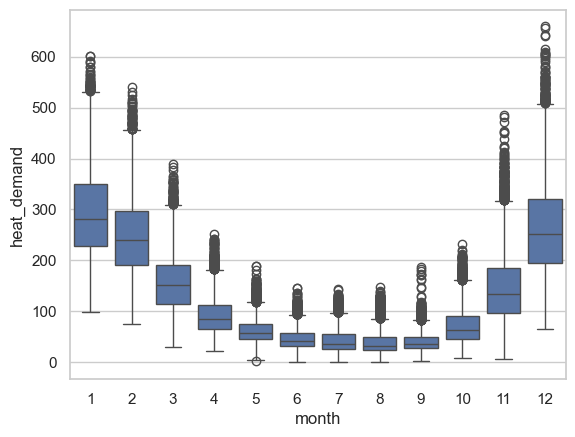

In [411]:
sns.boxplot(data=df_train_cluster2, x='month', y='heat_demand')


In [412]:
print(df_train_cluster2_summer[['heat_demand', 'ta']].describe())
print(df_train_cluster2_winter[['heat_demand', 'ta']].describe())


        heat_demand            ta
count  26494.000000  25147.000000
mean      43.171360     25.132509
std       22.535961      3.963745
min        0.000000     11.900000
25%       27.000000     22.600000
50%       37.000000     25.000000
75%       54.000000     27.800000
max      148.000000     37.500000
        heat_demand            ta
count  25916.000000  25768.000000
mean     268.690461     -0.417009
std       87.769446      6.003931
min       65.000000    -19.700000
25%      204.000000     -4.400000
50%      259.000000     -0.600000
75%      323.000000      3.900000
max      659.000000     21.500000


In [413]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(df_train_cluster2_summer['heat_demand'], df_train_cluster2_winter['heat_demand'], equal_var=False)
print(f"t-stat: {t_stat}, p-value: {p_val}")


t-stat: -400.9159788392416, p-value: 0.0


In [416]:
corr_summer = df_train_cluster2_summer.corr(numeric_only=True)['heat_demand'].sort_values(ascending=False)
corr_winter = df_train_cluster2_winter.corr(numeric_only=True)['heat_demand'].sort_values(ascending=False)

corr_compare = pd.concat([corr_summer, corr_winter], axis=1)
corr_compare.columns = ['summer_corr', 'winter_corr']
corr_compare['diff'] = (corr_compare['summer_corr'] - corr_compare['winter_corr']).abs()
corr_compare.sort_values('diff', ascending=False)


,summer_corr,winter_corr,diff
ta,0.274554,-0.574160,0.848714
ta_chi,0.220770,-0.577729,0.798499
si,0.342744,-0.135898,0.478642
ws,0.212982,-0.124944,0.337926
hm,-0.312239,-0.052193,0.260045
hour_group,0.291142,0.043699,0.247443
hour,0.289050,0.043076,0.245974
rn_day,0.052185,-0.075372,0.127557
day,-0.048003,0.057967,0.105970
year,0.057026,-0.034794,0.091820


C:\Users\smlee\AppData\Local\Temp\ipykernel_27972\3299216290.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_corr = df.groupby('month').apply(


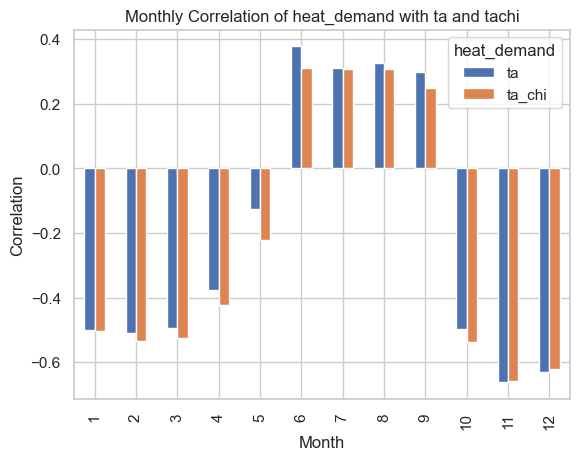

In [ ]:
def calculate_monthly_correlation(df):
    # 월별 그룹화 후 heat_demand와 ta, tachi 간 상관계수 계산
    monthly_corr = df.groupby('month').apply(
        lambda x: x[['heat_demand', 'ta', 'ta_chi']].corr().loc['heat_demand', ['ta', 'ta_chi']]
    )
    return monthly_corr

monthly_corr = calculate_monthly_correlation(df_train_cluster2)
monthly_corr.plot(kind='bar')
plt.title('Monthly Correlation of heat_demand with ta and tachi')
plt.ylabel('Correlation')
plt.xlabel('Month')
plt.show()


C:\Users\smlee\AppData\Local\Temp\ipykernel_27972\2723978576.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_corr = df.groupby('month').apply(


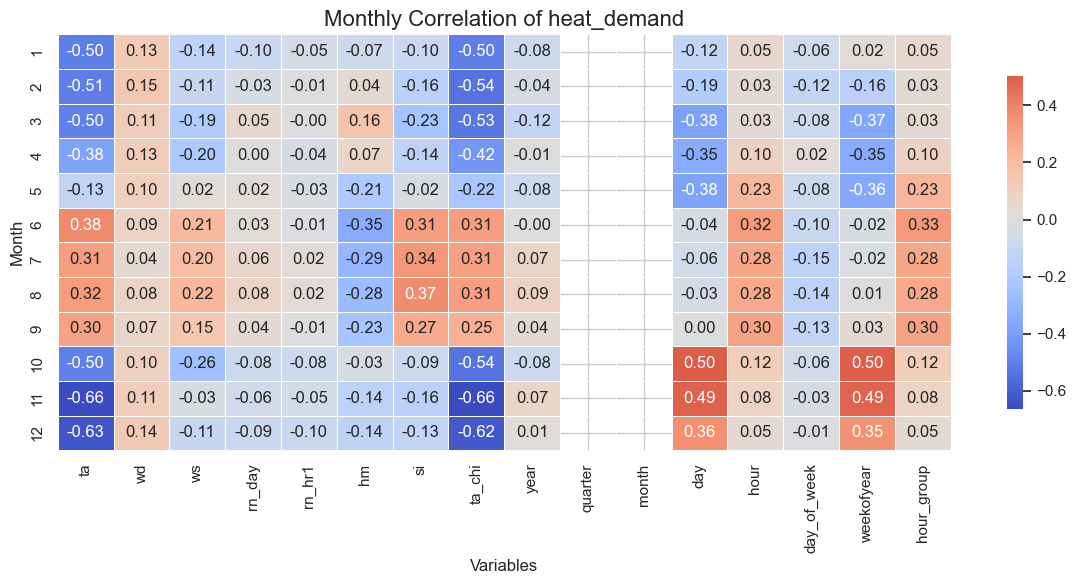

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_monthly_correlation(df):
    monthly_corr = df.groupby('month').apply(
        lambda x: x.corr(numeric_only=True)['heat_demand']
    )
    return monthly_corr.drop(columns=['heat_demand'], errors='ignore')

# 상관계수 계산
monthly_corr = calculate_monthly_correlation(df_train_cluster2)

# 인덱스와 컬럼 정렬(월, 변수명)
monthly_corr = monthly_corr.sort_index()

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.heatmap(
    monthly_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title('Monthly Correlation of heat_demand', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [446]:
def calculate_monthly_correlation_by_branch(df):
    def corr_heat_demand(x):
        corr = x.corr(numeric_only=True)
        return corr.loc['heat_demand'].drop('heat_demand')
    # branch, month별로 그룹화해서 상관계수 계산
    monthly_branch_corr = df.groupby(['branch_id', 'month']).apply(corr_heat_demand)
    return monthly_branch_corr


In [447]:
monthly_branch_corr = calculate_monthly_correlation_by_branch(df_train_cluster2)


C:\Users\smlee\AppData\Local\Temp\ipykernel_27972\769252016.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_branch_corr = df.groupby(['branch_id', 'month']).apply(corr_heat_demand)


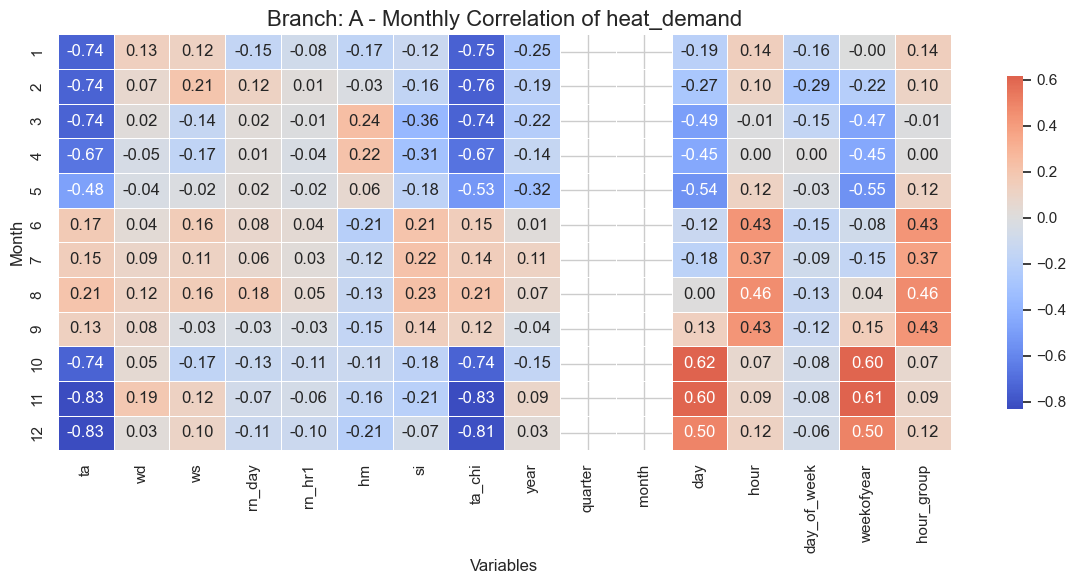

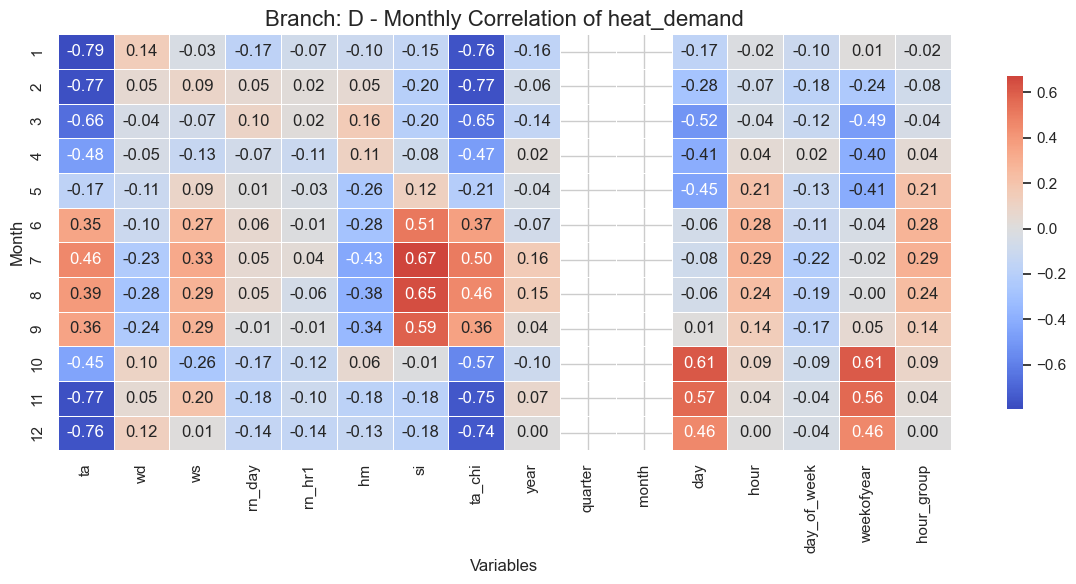

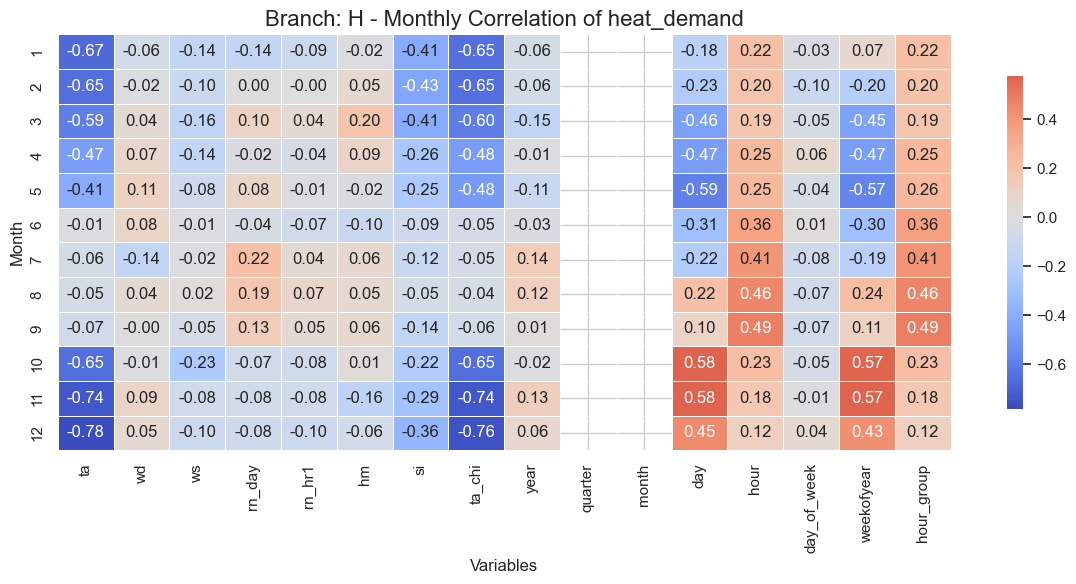

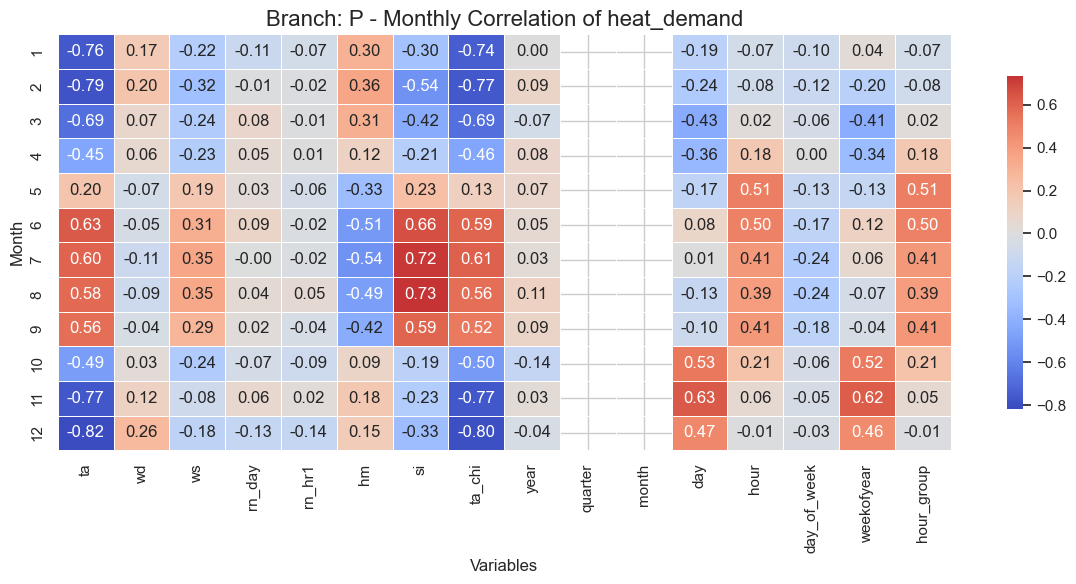

In [ ]:
# branch별로 반복해서 히트맵 그림
for branch in monthly_branch_corr.index.get_level_values('branch_id').unique():
    branch_corr = monthly_branch_corr.loc[branch]
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        branch_corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )
    plt.title(f'Branch: {branch} - Monthly Correlation of heat_demand', fontsize=16)
    plt.xlabel('Variables', fontsize=12)
    plt.ylabel('Month', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [456]:
branch_dfs = {}  # branch_id를 key로, df를 value로 저장할 dict

for branch in df_train_cluster2['branch_id'].unique():
    df_branch = df_train_cluster2[df_train_cluster2['branch_id'] == branch].copy()

    # 원하는 피처 엔지니어링 수행
    df_branch = make_shift_features(df_branch, value_col='ta', time_col='tm', shifts=[1, 3, 5, 7,24], prefix='ta')
    df_branch = add_shifted_features(df_branch, exclude_cols=['heat_demand'], max_shift=23)

    # dict에 저장
    branch_dfs[branch] = df_branch


In [475]:
def add_season_column(df):
    df = df.copy()
    df['season'] = df['month'].apply(lambda x: 'summer' if x in [6,7,8,9] else 'not_summer')
    return df


In [478]:
# 1. 계절 컬럼 추가
branch_dfs_season = {k: add_season_column(v) for k, v in branch_dfs.items()}

# 2. 브랜치, 계절별 상관계수 계산 함수
def corr_by_branch_and_season(branch_dfs_season):
    results = {}
    for branch, df in branch_dfs_season.items():
        for season in ['summer', 'not_summer']:
            df_season = df[df['season'] == season]
            corr = df_season.corr(numeric_only=True)['heat_demand'].sort_values(ascending=True)
            results[(branch, season)] = corr
    return results

# 3. 함수 실행 및 결과 출력
results = corr_by_branch_and_season(branch_dfs_season)

for (branch, season), corr in results.items():
    print(f'\n=== Branch: {branch}, Season: {season} ===')
    print(corr)



=== Branch: A, Season: summer ===
si_shift_14h           -0.421466
hour_group_shift_8h    -0.407857
hour_shift_8h          -0.406343
si_shift_15h           -0.399533
si_shift_13h           -0.394922
                          ...   
hour                    0.402086
hour_group              0.404271
hour_shift_23h          0.406802
hour_group_shift_23h    0.411004
heat_demand             1.000000
Name: heat_demand, Length: 625, dtype: float64

=== Branch: A, Season: not_summer ===
ta_chi_shift_1h   -0.915613
ta_chi            -0.915597
ta_shift_1h       -0.910447
ta_chi_shift_2h   -0.910208
ta                -0.909530
                     ...   
ws_shift_10h       0.246379
ws_shift_7h        0.246504
ws_shift_9h        0.250539
ws_shift_8h        0.250860
heat_demand        1.000000
Name: heat_demand, Length: 625, dtype: float64

=== Branch: D, Season: summer ===
hour_group_shift_8h   -0.619672
hour_shift_8h         -0.615410
hour_group_shift_7h   -0.584496
hour_shift_7h         -0.58041

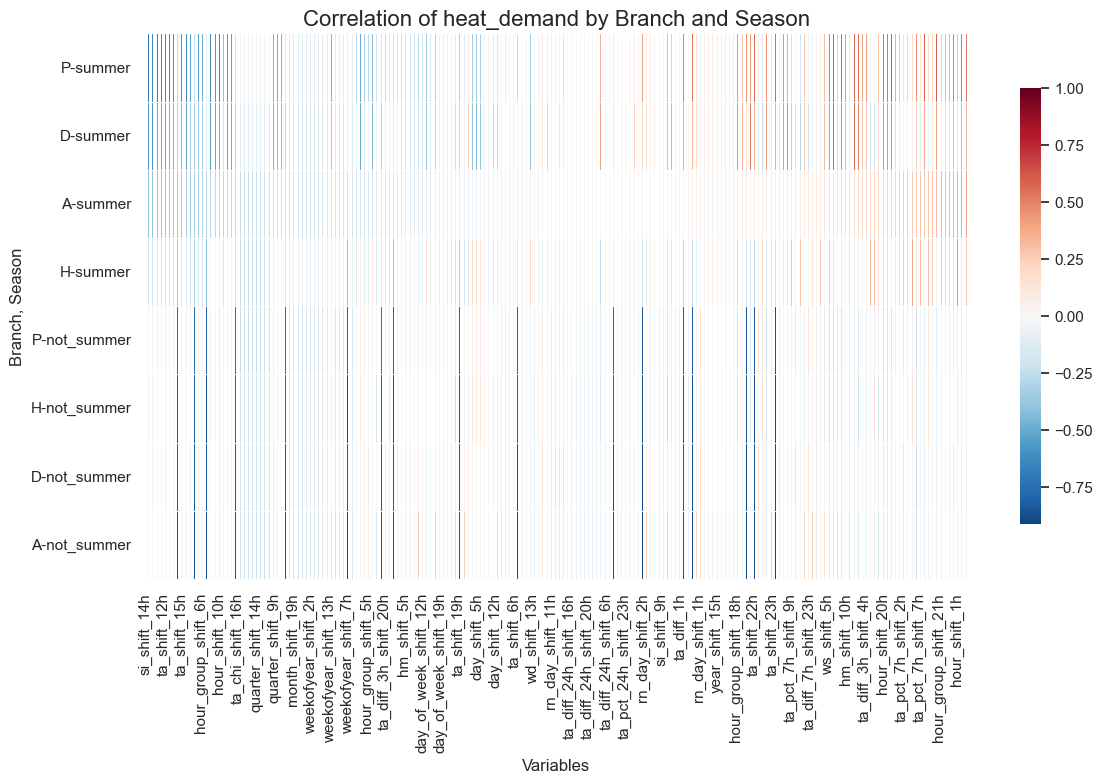

In [483]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. results 딕셔너리를 DataFrame으로 변환
combined_df = pd.DataFrame.from_dict(results, orient='index')
combined_df.index.names = ['branch', 'season']

# 2. 예시: ta 상관계수 기준으로 내림차순 정렬
sorted_df = combined_df.sort_values(by='ta', ascending=False)

# 3. 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(
    sorted_df,
    annot=False,
    fmt='.2f',
    cmap='RdBu_r',  # 가독성 좋은 컬러맵
    center=0,
    linewidths=.5,
    cbar_kws={'shrink': .8}
)

plt.title('Correlation of heat_demand by Branch and Season', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Branch, Season', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [497]:
def sorted_corr_vars_by_season(branch_dfs_season, threshold=0.3):
    results = {}
    for branch, df in branch_dfs_season.items():
        for season in ['summer', 'not_summer']:
            df_season = df[df['season'] == season]
            corr = df_season.corr(numeric_only=True)['heat_demand'].drop('heat_demand')
            # threshold 이상인 것만 남기고, 절대값 내림차순 정렬
            corr_filtered = corr[abs(corr) >= threshold]
            corr_sorted = corr_filtered.reindex(abs(corr_filtered).sort_values(ascending=False).index)
            results[(branch, season)] = corr_sorted
    return results


In [498]:
sorted_vars_results = sorted_corr_vars_by_season(branch_dfs_season, threshold=0.3)


In [499]:
for season in ['summer', 'not_summer']:
    print(f"\n========== {season.upper()} ==========")
    for branch in branch_dfs_season.keys():
        corr_series = sorted_vars_results.get((branch, season))
        print(f"\n[Branch: {branch}]")
        if corr_series is not None and not corr_series.empty:
            print(corr_series)
        else:
            print("해당 조건을 만족하는 변수가 없습니다.")



========== SUMMER ==========

[Branch: A]
si_shift_14h           -0.421466
hour_group_shift_23h    0.411004
hour_group_shift_8h    -0.407857
hour_shift_23h          0.406802
hour_shift_8h          -0.406343
                          ...   
hour_shift_21h          0.307187
hour_group_shift_6h    -0.302813
ta_pct_3h_shift_18h    -0.301492
ta_diff_7h_shift_3h     0.300720
hour_shift_6h          -0.300061
Name: heat_demand, Length: 69, dtype: float64

[Branch: D]
hour_group_shift_8h    -0.619672
hour_shift_8h          -0.615410
si                      0.604709
ta_diff_7h              0.591870
hour_group_shift_7h    -0.584496
                          ...   
ta_pct_1h_shift_13h    -0.304616
ta_shift_8h            -0.304432
hm_shift_7h             0.304046
ta_pct_7h_shift_9h     -0.302641
ta_diff_5h_shift_10h   -0.300288
Name: heat_demand, Length: 186, dtype: float64

[Branch: H]
hour_group_shift_1h    0.441613
hour_shift_1h          0.440803
ta_chi_shift_15h      -0.425429
ta_chi_shift_16h

In [500]:
def get_common_sorted_vars(sorted_vars_results, branches=['A','D','H','P'], season='summer'):
    # 각 브랜치별 변수 set
    var_sets = [set(sorted_vars_results[(branch, season)].index) for branch in branches if (branch, season) in sorted_vars_results]
    if not var_sets:
        return []
    common_vars = set.intersection(*var_sets)
    # 각 변수의 평균 상관계수로 정렬
    avg_corr = {var: np.mean([abs(sorted_vars_results[(branch, season)].get(var, 0)) for branch in branches]) for var in common_vars}
    sorted_common = sorted(avg_corr.items(), key=lambda x: -x[1])
    return sorted_common

import numpy as np

for season in ['summer', 'not_summer']:
    sorted_common = get_common_sorted_vars(sorted_vars_results, list(branch_dfs_season.keys()), season)
    print(f"\n{season.upper()} 공통 변수 (브랜치별 평균|corr| 내림차순):")
    for var, avg in sorted_common:
        print(f"{var}: 평균|corr|={avg:.3f}")



SUMMER 공통 변수 (브랜치별 평균|corr| 내림차순):
ta_shift_12h: 평균|corr|=0.336

NOT_SUMMER 공통 변수 (브랜치별 평균|corr| 내림차순):
ta_chi: 평균|corr|=0.885
ta: 평균|corr|=0.884
ta_chi_shift_1h: 평균|corr|=0.884
ta_shift_1h: 평균|corr|=0.883
ta_chi_shift_2h: 평균|corr|=0.876
ta_shift_2h: 평균|corr|=0.874
ta_chi_shift_23h: 평균|corr|=0.865
ta_chi_shift_3h: 평균|corr|=0.863
ta_shift_23h: 평균|corr|=0.862
ta_shift_3h: 평균|corr|=0.860
ta_chi_shift_22h: 평균|corr|=0.859
ta_shift_22h: 평균|corr|=0.857
ta_chi_shift_21h: 평균|corr|=0.853
ta_shift_21h: 평균|corr|=0.851
ta_chi_shift_20h: 평균|corr|=0.848
ta_chi_shift_4h: 평균|corr|=0.847
ta_shift_20h: 평균|corr|=0.846
ta_chi_shift_15h: 평균|corr|=0.845
ta_chi_shift_16h: 평균|corr|=0.845
ta_chi_shift_19h: 평균|corr|=0.845
ta_chi_shift_17h: 평균|corr|=0.844
ta_chi_shift_18h: 평균|corr|=0.844
ta_shift_4h: 평균|corr|=0.843
ta_chi_shift_14h: 평균|corr|=0.843
ta_shift_19h: 평균|corr|=0.842
ta_shift_16h: 평균|corr|=0.842
ta_shift_15h: 평균|corr|=0.841
ta_shift_17h: 평균|corr|=0.841
ta_shift_18h: 평균|corr|=0.841
ta_shift_14h: 평균|corr|

In [507]:
# 공통 변수만 변수명(리스트)으로 출력
sorted_common = get_common_sorted_vars(sorted_vars_results, list(branch_dfs_season.keys()), season='not_summer')
common_var_names = [var for var, avg in sorted_common]

print("\nnot_summer 공통 변수명 리스트:")
print(sorted(common_var_names))
print(f"공통 변수 개수: {len(common_var_names)}")


not_summer 공통 변수명 리스트:
['ta', 'ta_chi', 'ta_chi_shift_10h', 'ta_chi_shift_11h', 'ta_chi_shift_12h', 'ta_chi_shift_13h', 'ta_chi_shift_14h', 'ta_chi_shift_15h', 'ta_chi_shift_16h', 'ta_chi_shift_17h', 'ta_chi_shift_18h', 'ta_chi_shift_19h', 'ta_chi_shift_1h', 'ta_chi_shift_20h', 'ta_chi_shift_21h', 'ta_chi_shift_22h', 'ta_chi_shift_23h', 'ta_chi_shift_2h', 'ta_chi_shift_3h', 'ta_chi_shift_4h', 'ta_chi_shift_5h', 'ta_chi_shift_6h', 'ta_chi_shift_7h', 'ta_chi_shift_8h', 'ta_chi_shift_9h', 'ta_shift_10h', 'ta_shift_11h', 'ta_shift_12h', 'ta_shift_13h', 'ta_shift_14h', 'ta_shift_15h', 'ta_shift_16h', 'ta_shift_17h', 'ta_shift_18h', 'ta_shift_19h', 'ta_shift_1h', 'ta_shift_20h', 'ta_shift_21h', 'ta_shift_22h', 'ta_shift_23h', 'ta_shift_2h', 'ta_shift_3h', 'ta_shift_4h', 'ta_shift_5h', 'ta_shift_6h', 'ta_shift_7h', 'ta_shift_8h', 'ta_shift_9h']
공통 변수 개수: 48
